# 0. Configuration setup

In [ ]:
# Standard library
import csv
import math
import pickle
import random
from os import cpu_count

# Third-party
from gpytorch.kernels import MaternKernel, ScaleKernel
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.means import ConstantMean

from guacamol.utils.data import get_random_subset, remove_duplicates

import matplotlib.pyplot as plt

import numpy as np

import optuna
from optuna.pruners import MedianPruner, SuccessiveHalvingPruner

import pandas as pd

from rdkit.Chem import Crippen, Descriptors, PandasTools
from rdkit.Chem.rdmolfiles import MolFromSmiles

from scipy.integrate import quad

import selfies
from selfies.utils.selfies_utils import len_selfies

from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import StandardScaler

import torch
from torch.utils.data import DataLoader, Subset, TensorDataset

from transformers import AutoTokenizer

import wandb

In [2]:
config = {
    "n_data": 750,											                                            #750(real)/25
    "device": torch.device("cuda"),
    "data_type": torch.float32,
    "seed": 3032,
    "tokenization": {
        "padding": "longest",
        "truncation": True,
        "max_length": 128,
        "return_tensors": "pt",
    },
    "optuna": {
        "seed": 64,
        "n_split": 3, # k-fold split
        "epoch": 25, #training epoch for optuna at each fold                                            #25(real)/8
        "n_trials": 30,                                                                                 #30(real)/5
	# For Median Pruner
        "n_startup_trials": 8, # number of full trial before pruner activates                           #2
        "n_warmup_steps": 5, # minimum number of step each trial had to complete before pruning
	# For Successive Halving Pruner
	    "min_resource": 15, # similar to the n_warmup_steps in median pruner                            
	    "reduction_factor": 2,
    },
    "decoder": {
        "epoch": 100,                                                                                   #10
        "max_loop": 10,
        "early_stop_tol": 1e-3,
        "patience": 3,
    },
	"analysis": {
        "n_data": 250,                                                                                  #25
        "q": 15,
        "num_restarts": 20,										                                        #5
        "raw_samples": 30,										                                        #20
        "sampler_n": 384,
        "iter_budget": 50,										                                        #5
        "initial_sample_num": 25,
	}
}

GOLLuM_config = {
    "standardize": True, 
    "normalize": False,
    "initial_noise_val": 1e-3,
    "initial_lengthscale_val": 10.0,
    "initial_outputscale_val": 1.0,
    "ft_lr": 1e-3,
    "gp_lr": 5e-2,
    "gp_step_lr": 0.9,
    "wd": 1e-4,
    "wd_llm": 1e-4,
    "scale_embeddings": False,
    "train_mll_additionally": True,
    # For LLMFeaturizer
    "model_name": "T5-base",
    "trainable": True,
    "target_ratio": 0.25,
    "from_top": True,
    "lora_dropout": 0.2,
    "modules_to_save": ["head"],
    "pooling_method": "average",
    "normalize_embeddings": False,
    "projection_dim": 64,
}

To ensure reproducibility of the notebook, we have tried to fix as many seed as possible.<br>
However, the hyperparameter tuning process is not reproducible as optuna refuses to accept `torch.backends.cudnn.deterministic = True`. Thus the rest of this notebook are still not reproducible.

In [3]:
seed = config["seed"]
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

# 1. Data Preparation
Pandas dataframe has been used as a basic data storage type.<br>

For this thesis, we will used `LogP` value as a property that we want to predict for the molecule and to optimize for molecular design. This is to keep the objective function simple via using the RDkit package to calculate `LogP` directly from its SMILES representation.<br>

SLEFIES string data was produced as it will be used for reconstruction of the molecular representation. Although SMILES are more widely used 1 dimensional molecular representation method, due to the fragile synthactic and low semantic nature of it, we believed SEFLIES string representation will be better especailly under the condition of limited data for training.<br>

`guacamol` is a widely used benchmark system for de novo molecular design. As one of its objective function, it uses `LogP` same as our approach and uses `chembl24_canon_train` and `chembl24_canon_test` files for training, validation, and test set. Although, `guacamol` benchmark is not directly applied in this thesis, to keep similar nature of the widely used benchmark to our training and analysis approach, and to have easier access to data, their datasets are used for this thesis as well. The `chembl24_canon_train` and `chembl24_canon_test` data was downloaded from https://figshare.com/projects/GuacaMol/56639 which is from the `Guacamol` Github. To ensure randomly and non-biased data, we used the `get_random_subset` and `remove_duplicates` functions of the `guacamol` package.

## 1.1 Data preparation

In [ ]:
train_path = r"data/chembl24_canon_train.smiles"

with open(train_path, newline="", encoding="utf-8") as f:
    reader = csv.reader(f)
    smiles = [row[0].strip() for row in reader if row and row[0].strip()]

unique_smiles = remove_duplicates(smiles)

n = min(config["n_data"], len(unique_smiles))
final_set = get_random_subset(dataset=unique_smiles, subset_size=n, seed=config["seed"])
final_set = [str(x) for x in final_set]

print(f"Number of molecules in training + validation set: {n}")

with open("Notebook_result_1/training_validation_strings.txt", "w") as file:
    file.write("\n".join(map(str, final_set)))

Number of molecules in training + validation set: 750


In [5]:
train_df = pd.DataFrame(final_set, columns=["SMILES"])
PandasTools.AddMoleculeColumnToFrame(train_df, "SMILES", "rdkit_Mol")

In [6]:
train_df['SELFIES'] = [selfies.encoder(m) for m in train_df['SMILES']]
train_df['LogP'] = [Crippen.MolLogP(m) for m in train_df['rdkit_Mol']]

In [7]:
all_characters = [selfies.split_selfies(s) for s in train_df["SELFIES"]]

pad_token = "[nop]"
eos_token = "[eos]"
bos_token = "[bos]"

unique_tokens = set(tok for seq in all_characters for tok in seq)

all_tokens = [pad_token, eos_token, bos_token] + sorted(unique_tokens)

vocab_key = {all_tokens[i]: i for i in range(len(all_tokens))}
int_key = {i: all_tokens[i] for i in range(len(all_tokens))}

selfies_count = np.array([len_selfies(s) for s in train_df["SELFIES"]])
pad_to_length = int(selfies_count.max())

labels_list = []
onehot_list = []
for s in train_df["SELFIES"]:
    labels, one_hot = selfies.selfies_to_encoding(
        s, vocab_key, enc_type="both", pad_to_len=pad_to_length
    )
    labels_list.append(np.asarray(labels, dtype=np.int64))
    onehot_list.append(np.asarray(one_hot, dtype=np.float32))

train_df["SELFIES_label"] = list(labels_list)
train_df["SELFIES_one_hot"] = list(onehot_list)

pad_id = vocab_key["[nop]"]
eos_id = vocab_key["[eos]"]
bos_id = vocab_key["[bos]"]
V = len(vocab_key)

with open("Notebook_result_1/vocab_key.txt", "w") as file:
    for k, v in vocab_key.items():
        file.write(f"{k}: {v}\n")

vocab_int_V = {"vocab_key": vocab_key, "int_key": int_key, "V":V}
with open("Notebook_result_1/vocab_int_V.pickle", "wb") as file:
    pickle.dump(vocab_int_V, file)

with open("Notebook_result_1/train_df.pickle", "wb") as file:
    pickle.dump(train_df, file)

train_df.head()

,SMILES,rdkit_Mol,SELFIES,LogP,SELFIES_label,SELFIES_one_hot
0,O=C1C=C(c2ccc(F)cc2OCc2ccccc2)CC(c2ccc(Cl)cc2)C1,<rdkit.Chem.rdchem.Mol object at 0x00000184036...,[O][=C][C][=C][Branch2][Ring1][=Branch1][C][=C...,6.58820,"[33, 10, 24, 10, 22, 35, 8, 24, 10, 24, 10, 21...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,N=C(O)N1CCCc2cc(-c3cncc(C4CC4)c3)cnc21,<rdkit.Chem.rdchem.Mol object at 0x00000184616...,[N][=C][Branch1][C][O][N][C][C][C][C][=C][C][B...,3.26637,"[31, 10, 21, 24, 33, 31, 24, 24, 24, 24, 10, 2...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,COc1ccc(OC)c(S(=O)(=O)N2CCc3ccccc3C2)c1,<rdkit.Chem.rdchem.Mol object at 0x00000184616...,[C][O][C][=C][C][=C][Branch1][Ring1][O][C][C][...,2.45080,"[24, 33, 24, 10, 24, 10, 21, 35, 33, 24, 24, 2...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,CCN1c2ncc(COc3cc[n+]([O-])cc3)cc2C(=O)N(C)c2cc...,<rdkit.Chem.rdchem.Mol object at 0x00000184616...,[C][C][N][C][=N][C][=C][Branch1][=C][C][O][C][...,3.09040,"[24, 24, 31, 24, 13, 24, 10, 21, 10, 24, 33, 2...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,CC(C)(C#Cc1ccc2c(c1)-c1nc(C(N)=O)cn1CCO2)CO,<rdkit.Chem.rdchem.Mol object at 0x00000184616...,[C][C][Branch1][C][C][Branch2][Ring1][S][C][#C...,1.41140,"[24, 24, 21, 24, 24, 22, 35, 38, 24, 5, 24, 10...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


## 1.2 Data distribution analysis and visualization

-4.712699999999988 11.810399999999985 0.8696368421052618


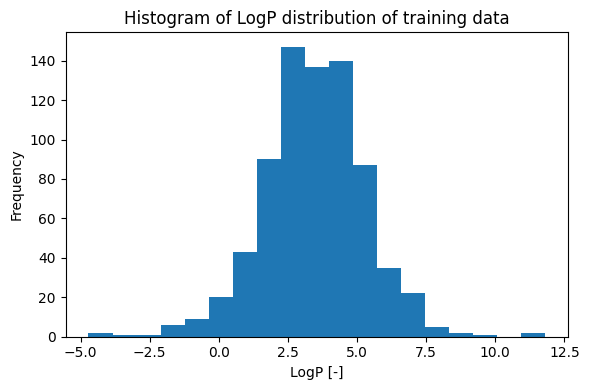

In [8]:
train_min, train_max= train_df["LogP"].min(), train_df["LogP"].max()
step = (train_max - train_min)/19
print(train_min, train_max, step)

plt.figure(figsize=(6, 4))
plt.hist(train_df["LogP"].to_numpy(), bins=np.arange(train_min, train_max+step, step).tolist())
plt.xlabel("LogP [-]")
plt.ylabel("Frequency")
plt.title("Histogram of LogP distribution of training data")
plt.tight_layout()
plt.savefig("Notebook_result_1/LogP_distirbution histogram.png", bbox_inches='tight')
plt.show()


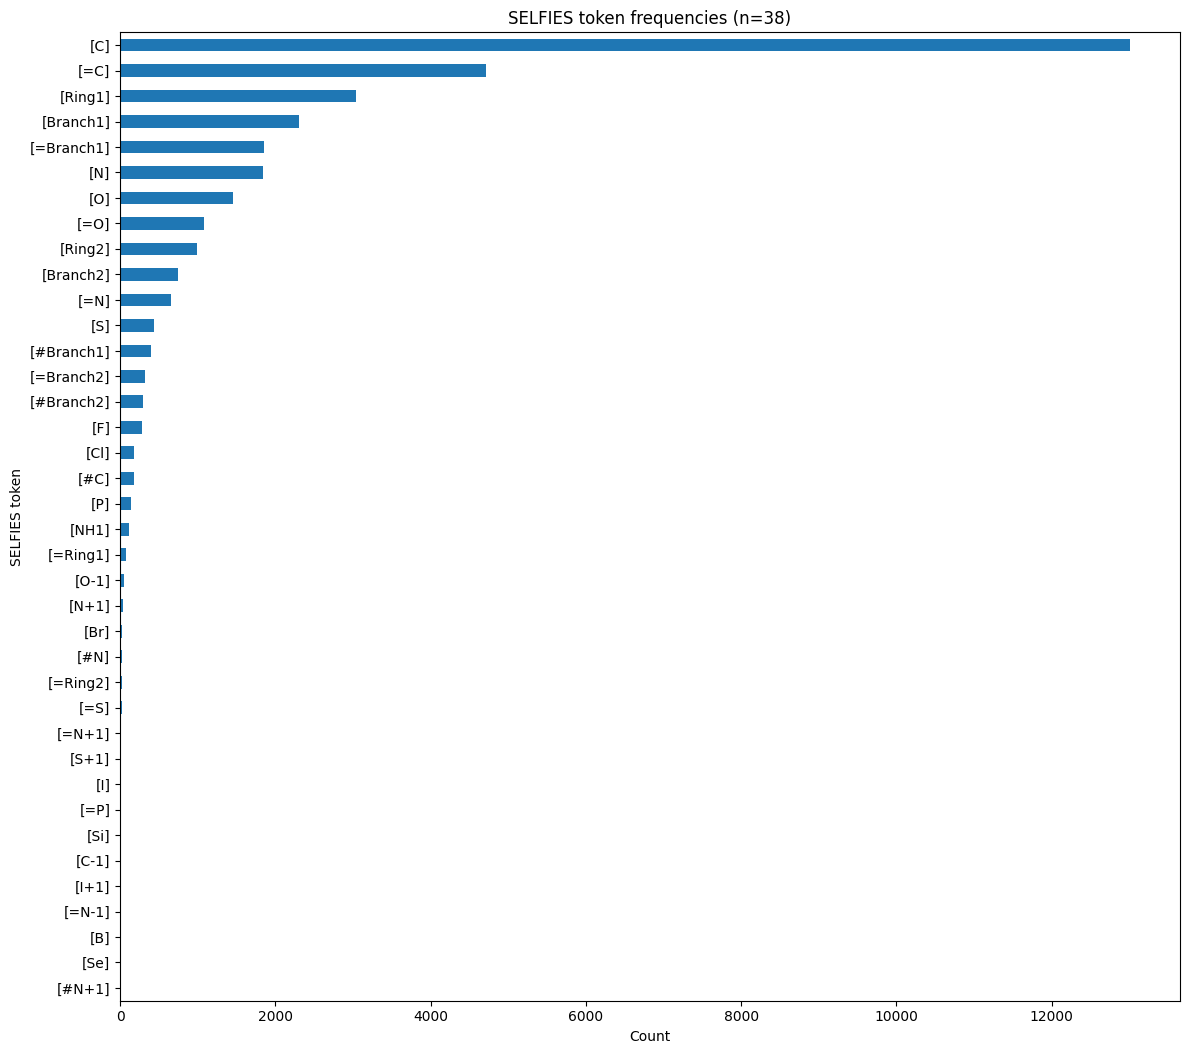

In [9]:
token_counts = (
    train_df["SELFIES"]
    .map(lambda s: list(selfies.split_selfies(s)))
    .explode()
    .value_counts()
)

counts_all = token_counts.sort_values(ascending=True)
n_tokens = len(counts_all)
fig_height = max(6, min(0.28 * n_tokens, 40))

ax = counts_all.plot(kind="barh", figsize=(12, fig_height)) #(6, 4)
ax.set_xlabel("Count")
ax.set_ylabel("SELFIES token")
ax.set_title(f"SELFIES token frequencies (n={n_tokens})")
plt.tight_layout()
plt.savefig("Notebook_result_1/train_df token distribution.png", bbox_inches='tight')
plt.show()

# 2. GOLLuM Training
For training the GOLLuM architecture, SMILES string was used as a data after converting it into a prompt, while the GP prediction is trained to make prediction on the LogP value. <br>
Hyperparameters of the GOLLuM architecture was kept identical as the literature.
## 2.1. Setup
We disable WandB’s online logging for now (no credentials needed), then pull in all the pieces of GOLLuM we reconstructed.

In [10]:
wandb.init(project="gollum_test", mode="disabled")

## 2.2. Tokenize & build raw features
We convert each SMILES into a text prompt, tokenize with the LLM’s tokenizer,then concatenate input IDs and attention mask into one tensor per example. This raw tensor `train_x_raw` is exactly what our `LLMFeaturizer` expects.

In [11]:
from util.gollum_util import make_template

prompts = [make_template(smi) for smi in train_df["SMILES"].tolist()]

tokenizer = AutoTokenizer.from_pretrained("t5-base", trust_remote_code=True)
tokenizer.pad_token = tokenizer.pad_token or tokenizer.eos_token

tokenized_smiles = tokenizer(
    prompts,
    padding=config["tokenization"]["padding"],
    truncation=config["tokenization"]["truncation"],
    max_length=config["tokenization"]["max_length"],
    return_tensors=config["tokenization"]["return_tensors"],
)

train_x_raw = torch.cat(
    [tokenized_smiles["input_ids"], tokenized_smiles["attention_mask"]], dim=1
)

train_x_raw = train_x_raw.to(config["device"])

train_y = (
    torch.tensor(train_df["LogP"].values, dtype=config["data_type"])
    .unsqueeze(-1)
    .to(config["device"])
)

## 2.3. Build & initialize the DeepGP
We wrap our featurizer into a single‐task GP.
- GaussianLikelihood for regression noise
- ConstantMean + Matern-5/2 kernel wrapped in a ScaleKernel

In [12]:
from model.gollum_DeepGP import DeepGP

likelihood = GaussianLikelihood()
mean_module = ConstantMean()
covar_module = ScaleKernel(base_kernel=MaternKernel(nu=2.5, ard_num_dims=GOLLuM_config["projection_dim"]))

gollum_architecture = DeepGP(
    train_x=train_x_raw,
    train_y=train_y,
    likelihood=likelihood,
    mean_module=mean_module,
    covar_module=covar_module,
    standardize=GOLLuM_config["standardize"],
    normalize=GOLLuM_config["normalize"],
    initial_noise_val=GOLLuM_config["initial_noise_val"],
    initial_lengthscale_val=GOLLuM_config["initial_lengthscale_val"],
    initial_outputscale_val=GOLLuM_config["initial_outputscale_val"],
    ft_lr=GOLLuM_config["ft_lr"],
    gp_lr=GOLLuM_config["gp_lr"],
    gp_step_lr=GOLLuM_config["gp_step_lr"],
    wd=GOLLuM_config["wd"],
    wd_llm=GOLLuM_config["wd_llm"],
    scale_embeddings=GOLLuM_config["scale_embeddings"],
    train_mll_additionally=GOLLuM_config["train_mll_additionally"],
    
    model_name=GOLLuM_config["model_name"],
    trainable=GOLLuM_config["trainable"],
    target_ratio=GOLLuM_config["target_ratio"],
    from_top=GOLLuM_config["from_top"],
    lora_dropout=GOLLuM_config["lora_dropout"],
    modules_to_save=GOLLuM_config["modules_to_save"],
    pooling_method=GOLLuM_config["pooling_method"],
    normalize_embeddings=GOLLuM_config["normalize_embeddings"],
    projection_dim = GOLLuM_config["projection_dim"],

    device = config["device"],
    data_type = config["data_type"],
)

Selected device = cuda
Selected data type = torch.float32
T5-base for LLM
LLM using device: cuda

Found 18 linear layers (top 25.0% of 12 layers):
Layer numbers selected: [9, 10, 11]
trainable params: 165,888 || all params: 109,794,432 || trainable%: 0.1511


In [13]:
print("CUDA available: ", __import__("torch").cuda.is_available())
print("Torch version:", torch.__version__)
print("Device that DeepGP thinks it is using", gollum_architecture.device)
print("DeepGP dtype:", gollum_architecture.data_type)
print("LLM dtype:", next(gollum_architecture.finetuning_model.llm.parameters()).dtype)

CUDA available:  True
Torch version: 2.7.1+cu128
Device that DeepGP thinks it is using cuda
DeepGP dtype: torch.float32
LLM dtype: torch.float32


## 2.4. Train (fit) the GOLLuM architecture
 
This will jointly optimize:
 - LoRA & projection weights in the LLMFeaturizer
 - GP hyperparameters (noise, lengthscale, outputscale, mean)

We simply call `.fit()` and plot for the loss function. <br>
For GOLLuM architecture, it is trained to minimise the `negative maximum log likelihood` function, but we additionally plot the mean squared error of `LogP` predicted from GOLLuM and that from RDkit.

Then we save all the parameters so that we can call `LoRA_only.pt` and `projection_only.pt` when we need to recall the latent coordinates of the molecules.

In [14]:
gollum_architecture.fit()

c:\Users\mccha\miniconda3\envs\FYP\Lib\site-packages\gpytorch\models\exact_gp.py:296: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


In [15]:
gollum_architecture.eval()
gollum_architecture.likelihood.eval()

LoRA_only = {
    k: v
    for k, v in gollum_architecture.finetuning_model.llm.state_dict().items()
    if "lora_" in k
}
torch.save(LoRA_only, "LoRA_only.pt")
torch.save(
    gollum_architecture.finetuning_model.projector.state_dict(),
    "projection_only.pt"
)

## 2.5 Plot of the training result
In the plot below, there is 2 `mll` and one `mse`. As Mean Squared Error (`mse`) is not used as loss function for GOLLuM training, there is no need for plot it during the training mode, while Negative Marginal Log Likelihood `mll` was, we it make sense to plot for both training and evaluation mode. The difference between the evaluation and training mode will essentially lie on whether the `LoRA_dropout` had been applied or not.

Negative MLL training history: [1.0553569793701172, 0.9984527826309204, 0.957390308380127, 0.9240344166755676, 0.8951343297958374, 0.8701639771461487, 0.8471686840057373, 0.8248170614242554, 0.8042636513710022, 0.7850584983825684, 0.7667902112007141, 0.7483110427856445, 0.7319619655609131, 0.715935230255127, 0.6999788284301758, 0.6862272024154663, 0.6715595126152039, 0.6594036221504211, 0.6462879180908203, 0.6346555352210999, 0.6231854557991028, 0.6117857694625854, 0.6032391786575317, 0.593792736530304, 0.5833556056022644, 0.5742677450180054, 0.5672695636749268, 0.5583721995353699, 0.5509760975837708, 0.5433228015899658, 0.5373494029045105, 0.5308263301849365, 0.5240792036056519, 0.5188831090927124, 0.5143486261367798, 0.5087757706642151, 0.5025928616523743, 0.49682092666625977, 0.4944813549518585, 0.4891589283943176, 0.48607274889945984, 0.4823426902294159, 0.4786822199821472, 0.47478538751602173, 0.4717683494091034, 0.46917855739593506, 0.46569767594337463, 0.46199658513069153, 0.460

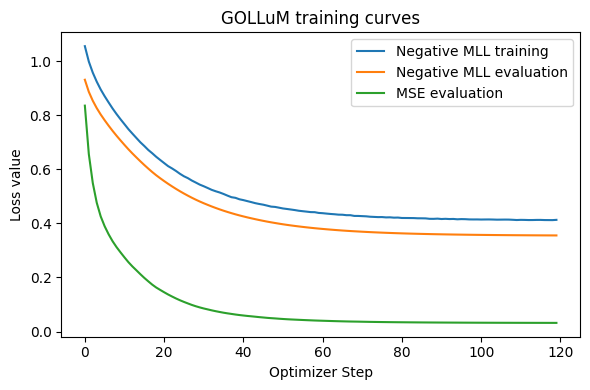

In [16]:
print("Negative MLL training history:", gollum_architecture.mll_history)
print("Negative MLL evaluation history:", gollum_architecture.mll_eval_history)
print("MSE evaluation history:", gollum_architecture.mse_eval_history)

gollum_train_result = {"mll_training": gollum_architecture.mll_history, "mll_eval":gollum_architecture.mll_eval_history, "mse": gollum_architecture.mse_eval_history}
with open("Notebook_result_1/gollum_train_result.pickle", 'wb') as file:
    pickle.dump(gollum_train_result, file)

plt.figure(figsize=(6, 4))
plt.plot(gollum_architecture.mll_history, label="Negative MLL training")
plt.plot(gollum_architecture.mll_eval_history, label="Negative MLL evaluation")
plt.plot(gollum_architecture.mse_eval_history, label="MSE evaluation")
plt.xlabel("Optimizer Step")
plt.ylabel("Loss value")
plt.title("GOLLuM training curves")
plt.legend()
plt.tight_layout()
plt.savefig("Notebook_result_1/GOLLuM_training_curves.png", bbox_inches='tight')
plt.show()

In [17]:
with torch.no_grad():
    y = gollum_architecture.train_y.squeeze()
    mu = gollum_architecture.posterior(
        gollum_architecture.train_x, observation_noise=True
    ).mean.squeeze()
    mse = torch.nn.functional.mse_loss(mu, y)
    var = y.var(unbiased=True)
    r2 = 1 - mse/var
print("MSE:", mse.item(), " Var:", var.item(), " R^2:", r2.item())
print("Learned noise σ²:", gollum_architecture.likelihood.noise.item())
print("Length scale:", gollum_architecture.covar_module.base_kernel.lengthscale.detach().cpu().numpy())
with open("Notebook_result_1/gollum_training_result.txt", "w") as file:
    file.write(f"MSE: {mse.item():.6g}\n")
    file.write(f"Var: {var.item():.6g}\n")
    file.write(f"R^2: {r2.item():.6g}\n")
    file.write(f"Learned noise σ²: {gollum_architecture.likelihood.noise.item():.6g}\n")
    file.write(f"length sacle: {gollum_architecture.covar_module.base_kernel.lengthscale.detach().cpu().numpy()}")

MSE: 0.015312500298023224  Var: 3.4806790351867676  R^2: 0.995600700378418
Learned noise σ²: 0.007240347098559141
Length scale: [[1.1713398  1.2590647  1.2241535  1.2695881  1.176586   1.1554053
  1.3033736  1.1599728  1.2027028  0.88948995 1.1996386  1.2519684
  1.2370425  0.9508408  1.2040972  1.2057862  1.21817    0.92129004
  0.9722326  0.699747   0.87601084 1.2694674  1.2401824  1.1387112
  1.1356882  1.1904858  1.0236833  0.6855549  1.1519641  1.2122546
  1.1479771  1.2090843  1.2433343  1.1410061  0.77028054 1.1988624
  1.0272698  0.89597857 0.9991249  1.1586571  1.2758677  1.2310457
  0.70587915 0.9689569  1.1524371  1.1532973  1.1760032  1.1177697
  1.2674834  0.6421715  1.1436017  0.8623865  1.159793   1.0747132
  1.2275918  1.1076585  0.7446704  1.2285748  1.2012163  1.2070552
  1.281622   1.226076   1.0329494  0.7012015 ]]


# 3. Decoder Training
We have three decoders at the moment built in `model` folder:
 - `SimpleMLP`: very simple MLP with `nn.Linear`, `nn.Relu()`, and `nn.MSELoss()` function.
 - `GRU`: a mimic version of the decoder architecture of Gomez-Bombarelli et al. that used `GRU` and `Cross-Entropy loss function`.
 - `Vec2Text`: a decoder based on the Vec2Text reconstruction strategy by Morris et al. where `Conditional Generator` and `frozen encoders` will be used iteratively.

The decoders are trained on fixed embedding coordinates to reconstruct the SELFIES token.<br>
`SimpleMLP` and `GRU` uses the one-hot vector of the SELFIES token for teacher-forcing, while `Vec2Tect` uses label for teacher-forcing.
## 3.1 Data preprocessing
The SELFIES string of each molecules are already stored in the `train_df["SELFIES"]`, but we do not have the latent embedding coordinate of each molecule yet. As passing the data through LLM encoder every instance of training loop takes computational time, we prepare the latent embedding coordinates of all molecules and store in `train_df` for latter use.<br>
During the GOLLuM training, we already built `train_x_raw`, which is prompt + mask data, we will reuse them here for producing the latent embedding coordinates.<br>

In [18]:
from model.gollum_LLM import LLMFeaturizer

encoder = LLMFeaturizer(
    model_name=GOLLuM_config["model_name"],
    trainable=GOLLuM_config["trainable"],           # Although we are not training the GOLLuM architecture anymore, this will ensure the LoRA injection.
    target_ratio=GOLLuM_config["target_ratio"],
    from_top=GOLLuM_config["from_top"],
    lora_dropout=GOLLuM_config["lora_dropout"],
    modules_to_save=GOLLuM_config["modules_to_save"],
    pooling_method=GOLLuM_config["pooling_method"],
    normalize_embeddings=GOLLuM_config["normalize_embeddings"],
    projection_dim = GOLLuM_config["projection_dim"],

    device = config["device"],
    data_type = config["data_type"],
)

LoRA_ckpt = torch.load("LoRA_only.pt", map_location=config["device"])
projector_ckpt = torch.load("projection_only.pt", map_location=config["device"])

encoder.projector.load_state_dict(projector_ckpt, strict=True)
encoder.llm.load_state_dict(LoRA_ckpt, strict=False)

encoder.eval()

T5-base for LLM
LLM using device: cuda

Found 18 linear layers (top 25.0% of 12 layers):
Layer numbers selected: [9, 10, 11]
trainable params: 165,888 || all params: 109,794,432 || trainable%: 0.1511


LLMFeaturizer(
  (llm): PeftModel(
    (base_model): LoraModel(
      (model): T5EncoderModel(
        (shared): Embedding(32128, 768)
        (encoder): T5Stack(
          (embed_tokens): Embedding(32128, 768)
          (block): ModuleList(
            (0): T5Block(
              (layer): ModuleList(
                (0): T5LayerSelfAttention(
                  (SelfAttention): T5Attention(
                    (q): Linear(in_features=768, out_features=768, bias=False)
                    (k): Linear(in_features=768, out_features=768, bias=False)
                    (v): Linear(in_features=768, out_features=768, bias=False)
                    (o): Linear(in_features=768, out_features=768, bias=False)
                    (relative_attention_bias): Embedding(32, 12)
                  )
                  (layer_norm): T5LayerNorm()
                  (dropout): Dropout(p=0, inplace=False)
                )
                (1): T5LayerFF(
                  (DenseReluDense): T5DenseActDense(

In [19]:
with torch.no_grad():
    embeddings=encoder(train_x_raw).detach().cpu().numpy()
train_df["SMILES_embed"] = list(embeddings)
train_df.head()

,SMILES,rdkit_Mol,SELFIES,LogP,SELFIES_label,SELFIES_one_hot,SMILES_embed
0,O=C1C=C(c2ccc(F)cc2OCc2ccccc2)CC(c2ccc(Cl)cc2)C1,<rdkit.Chem.rdchem.Mol object at 0x00000184036...,[O][=C][C][=C][Branch2][Ring1][=Branch1][C][=C...,6.58820,"[33, 10, 24, 10, 22, 35, 8, 24, 10, 24, 10, 21...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[-0.47137564, -0.42426008, 0.028747117, 0.2600..."
1,N=C(O)N1CCCc2cc(-c3cncc(C4CC4)c3)cnc21,<rdkit.Chem.rdchem.Mol object at 0x00000184616...,[N][=C][Branch1][C][O][N][C][C][C][C][=C][C][B...,3.26637,"[31, 10, 21, 24, 33, 31, 24, 24, 24, 24, 10, 2...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[-0.41630822, -0.37650687, 0.08612065, 0.32234..."
2,COc1ccc(OC)c(S(=O)(=O)N2CCc3ccccc3C2)c1,<rdkit.Chem.rdchem.Mol object at 0x00000184616...,[C][O][C][=C][C][=C][Branch1][Ring1][O][C][C][...,2.45080,"[24, 33, 24, 10, 24, 10, 21, 35, 33, 24, 24, 2...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[-0.43449956, -0.3966636, 0.098200604, 0.27526..."
3,CCN1c2ncc(COc3cc[n+]([O-])cc3)cc2C(=O)N(C)c2cc...,<rdkit.Chem.rdchem.Mol object at 0x00000184616...,[C][C][N][C][=N][C][=C][Branch1][=C][C][O][C][...,3.09040,"[24, 24, 31, 24, 13, 24, 10, 21, 10, 24, 33, 2...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[-0.42153355, -0.3762072, 0.04364248, 0.271524..."
4,CC(C)(C#Cc1ccc2c(c1)-c1nc(C(N)=O)cn1CCO2)CO,<rdkit.Chem.rdchem.Mol object at 0x00000184616...,[C][C][Branch1][C][C][Branch2][Ring1][S][C][#C...,1.41140,"[24, 24, 21, 24, 24, 22, 35, 38, 24, 5, 24, 10...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[-0.415821, -0.376615, 0.073636875, 0.28330144..."


## 3.2 Data preparation
Here we actually prepare the `train_df["SMILES_embed"]`, `train_df["SELFIES_one_hot"]`, and `train_df["SELFIES_label"]` to train the decoder via `DataLoader`. <br>
Unlike the GOLLuM training, where is did not had any validation training set, via the `sklearn.model_selection.train_test_split` we prepare 20% of the `train_df` as a validation set.

In [20]:
X_train, X_val, Y_train, Y_val = train_test_split(train_df["SMILES_embed"], train_df["SELFIES_one_hot"], test_size=0.2)

X_train_np = np.stack(X_train.values)
X_val_np  = np.stack(X_val.values)
Y_train_np = np.stack(Y_train.values)
Y_val_np  = np.stack(Y_val.values)

X_train_tensor = torch.tensor(X_train_np, dtype=config["data_type"])
X_val_tensor = torch.tensor(X_val_np, dtype=config["data_type"])
Y_train_tensor = torch.tensor(Y_train_np, dtype=config["data_type"])
Y_val_tensor = torch.tensor(Y_val_np, dtype=config["data_type"])

In [21]:
train_data = TensorDataset(X_train_tensor, Y_train_tensor)
val_data = TensorDataset(X_val_tensor, Y_val_tensor)

In [22]:
Y_train_ids = Y_train_np.argmax(-1).astype(np.int64)
Y_val_ids   = Y_val_np.argmax(-1).astype(np.int64)

Y_train_ids = torch.tensor(Y_train_ids, dtype=torch.long)
Y_val_ids   = torch.tensor(Y_val_ids,   dtype=torch.long)

train_data_ids = TensorDataset(X_train_tensor, Y_train_ids)
val_data_ids   = TensorDataset(X_val_tensor,   Y_val_ids)

## 3.3 Hyperparameter tuning
As we have 3 decoder models, we will tune the hyperparameters of them separately.<br>
We employed k-fold (`k=3`) cross-validation to ensure minimal overfitting of the architecture.
### 3.3.1 SimpleMLP decoder hyperparameter tuning
- `hidden_dim` = hidden dimension
- `batch_size` = batch size for training
- `depth` = number of MLP layers
- `dropout` = MLP layer dropout
- `MLP_lr` = learning rate for backpropagation

In [23]:
from model.MLP_decoder import SimpleMLP

def MLP_param_opt(trial):
    hidden_dim = trial.suggest_categorical("hidden_dim", [128, 256, 512, 768])
    batch_size = trial.suggest_categorical("batch_size", [64, 96, 128, 192, 256])
    depth = trial.suggest_int("depth", 1, 6)
    dropout = trial.suggest_float("dropout", 0, 0.5)
    MLP_lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True)

    kf = KFold(n_splits=config["optuna"]["n_split"], shuffle=True, random_state=config["seed"])
    all_indices = np.arange(len(train_data))

    val_losses: list[float] = []
    patience, min_delta = 5, 1e-4
    max_epochs = config["optuna"]["epoch"] 

    for fold, (train_idx, val_idx) in enumerate(kf.split(all_indices), 1):
        train_subset = Subset(train_data, train_idx)
        val_subset   = Subset(train_data, val_idx)
        train_loader = DataLoader(train_subset, batch_size, shuffle=True,  drop_last=False)
        val_loader   = DataLoader(val_subset,   batch_size, shuffle=False, drop_last=False)

        model = SimpleMLP(
            input_dim=GOLLuM_config["projection_dim"],
            hidden_dim=hidden_dim,
            output_dim=tuple(train_df["SELFIES_one_hot"].iloc[0].shape),
            depth=depth,
            dropout=dropout,
        ).to(config["device"])
        optimizer = torch.optim.Adam(model.parameters(), lr=MLP_lr)
        train_criterion = torch.nn.CrossEntropyLoss(ignore_index=pad_id, reduction="sum")
        eval_criterion = torch.nn.CrossEntropyLoss(ignore_index=pad_id, reduction="sum")

        best_val_loss = float("inf")
        wait = 0
        best_state= None
        best_epoch = -1

        for epoch in range(max_epochs):
            model.train()
            for X, Y in train_loader:
                X = X.to(config["device"])
                Y = Y.to(config["device"])

                optimizer.zero_grad()
                logits = model(X)
                B,L,V = logits.shape
                targets = Y.argmax(dim=-1).view(-1)
                
                loss = train_criterion(logits.view(B*L, V), targets)
                n_tokens = (targets != pad_id).sum().clamp_min(1)
                (loss / n_tokens).backward()
                optimizer.step()

            model.eval()
            val_loss_sum = 0.0
            val_token_sum = 0
            with torch.no_grad():
                for X, Y in val_loader:
                    X = X.to(config["device"])
                    Y = Y.to(config["device"])
                    logits = model(X)
                    targets = Y.argmax(dim=-1).view(-1)
                    B, L, V = logits.shape

                    loss = eval_criterion(logits.view(B*L, V), targets)
                    n_tokens = (targets != pad_id).sum().item()

                    val_loss_sum += loss.item()
                    val_token_sum += n_tokens
            avg_val_loss = val_loss_sum / max(1, val_token_sum)

            trial.report(avg_val_loss, step=(fold - 1) * max_epochs + epoch)
            if trial.should_prune():
                raise optuna.TrialPruned()

            if best_val_loss - avg_val_loss > min_delta:
                best_val_loss = avg_val_loss
                best_epoch = epoch
                wait = 0
                best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            else:
                wait += 1
                if wait >= patience:
                    break

        if best_state is not None:
            model.load_state_dict(best_state)  # restore for fairness

        val_losses.append(best_val_loss)

    # return the *best* validation CE seen in this trial
    trial.set_user_attr("best_epoch", best_epoch)
    return float(np.mean(val_losses))

MLP_sampler = optuna.samplers.TPESampler(seed=config["optuna"]["seed"])
MLP_study = optuna.create_study(
    direction="minimize", 
    pruner=MedianPruner(n_startup_trials=config["optuna"]["n_startup_trials"], n_warmup_steps=config["optuna"]["n_warmup_steps"]), 
    sampler=MLP_sampler
)
MLP_study.optimize(MLP_param_opt, n_trials=config["optuna"]["n_trials"])

MLP_param = MLP_study.best_params
print("Best hyperparams:", MLP_param)

with open("Notebook_result_1/SimpleMLP_Hyperparmeter.txt", "w") as file:
    file.write(f"Best hyperparams: {MLP_param}")

[I 2025-08-27 00:58:32,191] A new study created in memory with name: no-name-08410f95-c5a8-4454-b9f1-aaf018e16071
[I 2025-08-27 00:58:37,850] Trial 0 finished with value: 2.2424598876179993 and parameters: {'hidden_dim': 512, 'batch_size': 256, 'depth': 3, 'dropout': 0.3593751860924797, 'lr': 0.0004408349217592797}. Best is trial 0 with value: 2.2424598876179993.
[I 2025-08-27 00:58:40,196] Trial 1 finished with value: 2.9085632016039376 and parameters: {'hidden_dim': 128, 'batch_size': 96, 'depth': 1, 'dropout': 0.01783498438118214, 'lr': 0.00013501084566563734}. Best is trial 0 with value: 2.2424598876179993.
[I 2025-08-27 00:58:47,155] Trial 2 finished with value: 3.706438734502996 and parameters: {'hidden_dim': 512, 'batch_size': 256, 'depth': 5, 'dropout': 0.18791018371282553, 'lr': 1.1323063777498875e-05}. Best is trial 0 with value: 2.2424598876179993.
[I 2025-08-27 00:58:51,058] Trial 3 finished with value: 2.2555632940533052 and parameters: {'hidden_dim': 512, 'batch_size': 12

Best hyperparams: {'hidden_dim': 512, 'batch_size': 96, 'depth': 6, 'dropout': 0.16437850807129573, 'lr': 0.0001977194403058724}


### 3.3.2 GRU decoder hyperparameter tuning
- `middle_layer` = number of projection MLP layers
- `hg_growth_factor` = a factor that influence the growth of the hidden dimension in the middle layer
- `dropout_rate_mid` = middle layer dropout rate
- `gru_depth` = depth of the GRU layers excluding the final layer (due to fixed GRU on the final layer, `gru_depth - 1` is the actual number of GRU stack before the final GRU layer)
- `recurrent_dim` = Hidden size of the GRU stack and TerminalGRU input
- `temperature` = Softmax temperature for inference sampling in TerminalGRU
- `tgru_dropout` = Dropout inside TerminalGRU

In [24]:
from model.GRU_decoder import GRU
from util.decoder_util import build_adamW

def GRU_param_opt(trial):
    middle_layer = trial.suggest_int("middle_layer", 1, 2)
    hg_growth_factor = trial.suggest_float("hg_growth_factor", 0.9, 1.3)
    dropout_rate_mid = trial.suggest_float("dropout_rate_mid", 0, 0.5)
    gru_depth = trial.suggest_int("gru_depth", 1, 2)
    recurrent_dim = trial.suggest_categorical("recurrent_dim", [128, 192, 256, 320, 384])
    tgru_dropout = trial.suggest_float("tgru_dropout", 0, 0.5)
    temperature = trial.suggest_float("temperature", 0.7, 1.3)
    GRU_lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True)
    batch_size = trial.suggest_categorical("batch_size", [64, 96, 128])
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-2, log=True)
    
    kf = KFold(n_splits=config["optuna"]["n_split"], shuffle=True, random_state=config["seed"])
    all_indices = np.arange(len(train_data))

    val_losses: list[float] = []
    max_epochs = config["optuna"]["epoch"] 
    patience, min_delta = 5, 1e-4

    for fold, (train_idx, val_idx) in enumerate(kf.split(all_indices), 1):
        train_subset = Subset(train_data, train_idx)
        val_subset   = Subset(train_data, val_idx)
        train_loader = DataLoader(train_subset, batch_size, shuffle=True,  drop_last=False)
        val_loader   = DataLoader(val_subset,   batch_size, shuffle=False, drop_last=False)

        params = {
            "hidden_dim": GOLLuM_config["projection_dim"],
            "middle_layer": middle_layer,
            "hg_growth_factor": hg_growth_factor,
            "activation": "tanh",
            "dropout_rate_mid": dropout_rate_mid,
            "batchnorm_mid": True,
            "MAX_LEN": pad_to_length,
            "NCHARS": V,
            "gru_depth": gru_depth,
            "recurrent_dim": recurrent_dim,
            "do_tgru": True,
            "tgru_dropout": tgru_dropout,
            "temperature": temperature
        }
        model = GRU(params, bos_idx = bos_id).to(config["device"])
        optimizer = build_adamW(model=model, lr=GRU_lr, weight_decay=weight_decay)
        pad_idx = vocab_key["[nop]"]
        train_criterion = torch.nn.CrossEntropyLoss(ignore_index=pad_id, reduction="sum")
        eval_criterion = torch.nn.CrossEntropyLoss(ignore_index=pad_id, reduction="sum")

        smallest_dim = int(GOLLuM_config["projection_dim"] * (hg_growth_factor ** (middle_layer-1)))
        if smallest_dim < 1:
            raise optuna.TrialPruned()

        best_val_loss = float("inf")
        wait = 0
        best_state= None
        best_epoch = -1

        for epoch in range(max_epochs):
            model.train()
            for X, Y in train_loader:
                X, Y = X.to(config["device"]), Y.to(config["device"])
                targets = Y.argmax(dim=-1).to(config["device"])
                logits = model(X,Y)

                loss = train_criterion(logits.reshape(-1, V), targets.reshape(-1))
                optimizer.zero_grad(set_to_none=True)
                nonpad = (targets != pad_idx).sum().clamp_min(1)
                (loss / nonpad).backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()

            model.eval()
            total_val_loss = 0.0
            val_token_count = 0
            with torch.no_grad():
                for X, Y in val_loader:
                    X, Y = X.to(config["device"]), Y.to(config["device"])
                    targets = Y.argmax(dim=-1).to(config["device"])
                    logits = model(X,Y)
                    loss = eval_criterion(logits.reshape(-1, V), targets.reshape(-1))
                    nonpad = (targets != pad_idx).sum().item()
                    total_val_loss += loss.item()
                    val_token_count += nonpad
            avg_val_loss = total_val_loss / max(val_token_count, 1)

            trial.report(avg_val_loss, step=(fold - 1) * max_epochs + epoch)
            if trial.should_prune():
                raise optuna.TrialPruned()

            # per-trial early stopping
            if (best_val_loss - avg_val_loss) > min_delta:
                best_val_loss = avg_val_loss
                best_epoch = epoch
                wait = 0
                best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            else:
                wait += 1
                if wait >= patience:
                    break

        if best_state is not None:
            model.load_state_dict(best_state)  # restore for fairness

        val_losses.append(best_val_loss)

        # return the *best* validation CE seen in this trial
    trial.set_user_attr("best_epoch", best_epoch)
    return float(np.mean(val_losses))

GRU_sampler = optuna.samplers.TPESampler(seed=config["optuna"]["seed"])
GRU_study = optuna.create_study(
    direction="minimize", 
    pruner=MedianPruner(n_startup_trials=config["optuna"]["n_startup_trials"], n_warmup_steps=config["optuna"]["n_warmup_steps"]),
    sampler=GRU_sampler
)
GRU_study.optimize(GRU_param_opt, n_trials=config["optuna"]["n_trials"])

GRU_param = GRU_study.best_params
print("Best hyperparams:", GRU_param)

with open("Notebook_result_1/GRU_Hyperparmeter.txt", "w") as file:
    file.write(f"Best hyperparams: {GRU_param}")

[I 2025-08-27 01:00:00,687] A new study created in memory with name: no-name-edf9f370-b992-4f6c-b200-3a2a6b462fbc
[I 2025-08-27 01:02:45,396] Trial 0 finished with value: 2.264824716233189 and parameters: {'middle_layer': 1, 'hg_growth_factor': 1.1268392668718457, 'dropout_rate_mid': 0.29779625632856094, 'gru_depth': 1, 'recurrent_dim': 384, 'tgru_dropout': 0.19811101079970944, 'temperature': 1.1312502233109756, 'lr': 0.0004408349217592797, 'batch_size': 64, 'weight_decay': 6.8386073963926195e-06}. Best is trial 0 with value: 2.264824716233189.
[I 2025-08-27 01:04:17,936] Trial 1 finished with value: 3.2991113766092597 and parameters: {'middle_layer': 1, 'hg_growth_factor': 1.1538697768746746, 'dropout_rate_mid': 0.11222086959986965, 'gru_depth': 1, 'recurrent_dim': 128, 'tgru_dropout': 0.2024227414268301, 'temperature': 1.2195964801344161, 'lr': 5.850193899479681e-05, 'batch_size': 64, 'weight_decay': 5.054517965447178e-06}. Best is trial 0 with value: 2.264824716233189.
[I 2025-08-27

Best hyperparams: {'middle_layer': 2, 'hg_growth_factor': 1.1312806647840628, 'dropout_rate_mid': 0.14711931063926412, 'gru_depth': 2, 'recurrent_dim': 192, 'tgru_dropout': 0.292331429980366, 'temperature': 0.9538814917356042, 'lr': 0.004266712659326912, 'batch_size': 128, 'weight_decay': 0.0015644700553317634}


### 3.3.3 Vec2Text decoder hyperparameter tuning
Unfortunately, we could not tune the hyperparameters of the Vec2Text decoder model, mainly due to the constraint in computational budget. Therefore, we have pulled the analogy of original Vec2Text and GOLLuM configuration to makeup our own hyperparameters.

In [ ]:
from model.Vec2Text_decoder import Vec2Text
from transformers import T5ForConditionalGeneration

base_t5 = T5ForConditionalGeneration.from_pretrained("t5-small")
dropout = base_t5.config.dropout_rate
print("The default dropout_rate of the T5 small model is: ", dropout)

Vec2Text_param = {
    "EmbToSeq_hidden_dim": GOLLuM_config["projection_dim"],     #in Vec2Text "vec2text/models/corrector_encoder.py" line 25-29.
    "dropout": dropout,                                         #from Vec2Text literature, "vec2text/models/corrector_encoder.py" line 45
    "num_repeat_tokens": 16,                                    #from Vec2Text literature, "vec2text/tests/test_corrector_trainer.py" variable "DEFAULT_ARGS_STR"
    "LoRA_target_proportion": 0.25,                             #similar to GOLLuM
    "LoRA_r": 4,                                                #similar to GOLLuM
    "LoRA_alpha": 16,                                           #similar to GOLLuM
    "batch_size": 128,                                          #arbitrary
    "lr": 0.0003,                                               #from Vec2Text literature, "vec2text/tests/test_corrector_trainer.py" in variable "DEFAULT_ARGS_STR"
    "weight_decay": 0.005                                       #arbitrary
}

The default dropout_rate of the T5 small model is:  0.1


In [26]:
"""
from model.Vec2Text_decoder_original import Vec2Text

def Vec2Text_param_opt(trial):
    EmbToSeq_hidden_dim = trial.suggest_categorical("EmbToSeq_hidden_dim", [128, 192, 256, 320, 384, 512])
    dropout = trial.suggest_float("dropout", 0.1, 0.35) #combined LoRA_dropout and EmbToSeq_dropout to single dropout
    num_repeat_tokens = trial.suggest_categorical("num_repeat_tokens", [4, 6, 8])
    LoRA_target_proportion = trial.suggest_float("LoRA_target_proportion", 0.1, 0.2)
    LoRA_r = trial.suggest_int("LoRA_r", 1, 4)
    LoRA_alpha = trial.suggest_categorical("LoRA_alpha", [16, 32, 48, 64])
    batch_size = trial.suggest_categorical("batch_size", [32, 48, 64])
    lr = trial.suggest_float("lr", 1e-4, 1e-3, log=True) #combined corr_lr and base_lr to a single lr
    wd = trial.suggest_float("weight_decay", 1e-6, 3e-2, log=True)

    kf = KFold(n_splits=config["optuna"]["n_split"], shuffle=True, random_state=config["seed"])
    all_indices = np.arange(len(train_data_ids))

    fold_val_losses = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(all_indices), 1):
        train_subset_ids = Subset(train_data_ids, train_idx)
        val_subset_ids   = Subset(train_data_ids, val_idx)
        train_loader_ids = DataLoader(train_subset_ids, batch_size, shuffle=True,  drop_last=False, num_workers=min(8, cpu_count()), pin_memory=True)
        val_loader_ids   = DataLoader(val_subset_ids,   batch_size, shuffle=False, drop_last=False, num_workers=min(8, cpu_count()), pin_memory=True)

        report_offset = (fold - 1) * (2*config["optuna"]["epoch"])

        model = Vec2Text(
            latent_dim=GOLLuM_config["projection_dim"],
            EmbToSeq_hidden_dim=EmbToSeq_hidden_dim,
            EmbToSeq_dropout=dropout,
            num_repeat_tokens=num_repeat_tokens,
            LoRA_target_proportion=LoRA_target_proportion,
            LoRA_r=LoRA_r,
            LoRA_alpha=LoRA_alpha,
            LoRA_dropout=dropout,
            model_name=GOLLuM_config["model_name"],
            trainable=GOLLuM_config["trainable"],
            target_ratio=GOLLuM_config["target_ratio"],
            from_top=GOLLuM_config["from_top"],
            lora_dropout=GOLLuM_config["lora_dropout"],
            modules_to_save=GOLLuM_config["modules_to_save"],
            pooling_method=GOLLuM_config["pooling_method"],
            normalize_embeddings=GOLLuM_config["normalize_embeddings"],
            projection_dim = GOLLuM_config["projection_dim"],
            LLMFeaturizer_LoRA_ckpt=LoRA_ckpt,
            LLMFeaturizer_projector_ckpt=projector_ckpt,
            pad_idx_data = pad_id,
            vocab_size = V,
            eos_idx_data = eos_id,
            bos_idx_data = bos_id,
            max_length=config["tokenization"]["max_length"],
            device = config["device"],
            data_type = config["data_type"],
        )

        base_params = [p for p in model.initial_hypothesis.parameters() if p.requires_grad]
        corr_params = list(model.real_Emb2Seq.parameters()) \
                    + list(model.difference_Emb2Seq.parameters()) \
                    + list(model.predict_Emb2Seq.parameters()) \
                    + [p for p in model.corrector.parameters() if p.requires_grad]

        base_optimizer = torch.optim.AdamW(base_params, lr=lr, weight_decay=wd)
        corr_optimizer = torch.optim.AdamW(corr_params, lr=lr, weight_decay=wd)

        best_val_loss = model.fit(
            train_loader=train_loader_ids,
            val_loader=val_loader_ids,
            base_optimizer=base_optimizer,
            corr_optimizer=corr_optimizer,
            base_epochs=config["optuna"]["epoch"],
            corr_epochs=config["optuna"]["epoch"],
            corr_batch_size=batch_size,
            pad_idx_data=pad_id,
            trial=trial,
            weight=None,
            report_offset=report_offset,
            train_eval=False
        )
        fold_val_losses.append(best_val_loss)

    return float(sum(fold_val_losses) / len(fold_val_losses))

optuna.logging.enable_default_handler()
optuna.logging.disable_propagation()
optuna.logging.set_verbosity(optuna.logging.INFO)

Vec2Text_sampler = optuna.samplers.TPESampler(seed=config["optuna"]["seed"])
Vec2Text_study = optuna.create_study(
    direction="minimize", 
    pruner=SuccessiveHalvingPruner(min_resource=config["optuna"]["min_resource"], reduction_factor=config["optuna"]["reduction_factor"]), 
    sampler=Vec2Text_sampler
)
Vec2Text_study.optimize(Vec2Text_param_opt, n_trials=config["optuna"]["n_trials"])

Vec2Text_param = Vec2Text_study.best_params
print("Best hyperparams:", Vec2Text_param)

with open("Notebook_result_1/Vec2Text_Hyperparmeter.txt", "w") as file:
    file.write(f"Best hyperparams: {Vec2Text_param}")
"""

'\nfrom model.Vec2Text_decoder_original import Vec2Text\n\ndef Vec2Text_param_opt(trial):\n    EmbToSeq_hidden_dim = trial.suggest_categorical("EmbToSeq_hidden_dim", [128, 192, 256, 320, 384, 512])\n    dropout = trial.suggest_float("dropout", 0.1, 0.35) #combined LoRA_dropout and EmbToSeq_dropout to single dropout\n    num_repeat_tokens = trial.suggest_categorical("num_repeat_tokens", [4, 6, 8])\n    LoRA_target_proportion = trial.suggest_float("LoRA_target_proportion", 0.1, 0.2)\n    LoRA_r = trial.suggest_int("LoRA_r", 1, 4)\n    LoRA_alpha = trial.suggest_categorical("LoRA_alpha", [16, 32, 48, 64])\n    batch_size = trial.suggest_categorical("batch_size", [32, 48, 64])\n    lr = trial.suggest_float("lr", 1e-4, 1e-3, log=True) #combined corr_lr and base_lr to a single lr\n    wd = trial.suggest_float("weight_decay", 1e-6, 3e-2, log=True)\n\n    kf = KFold(n_splits=config["optuna"]["n_split"], shuffle=True, random_state=config["seed"])\n    all_indices = np.arange(len(train_data_ids)

## 3.4 Decoder training
Now after hyperparameter tuning, we start the actual training of the decoders.
### 3.4.1 SimpleMLP training

In [27]:
train_loader = DataLoader(train_data, batch_size=MLP_param["batch_size"], shuffle=True)
val_loader   = DataLoader(val_data,   batch_size=MLP_param["batch_size"], shuffle=False)

MLP_decoder = SimpleMLP(
    input_dim = GOLLuM_config["projection_dim"],
    hidden_dim = MLP_param["hidden_dim"],
    output_dim = train_df["SELFIES_one_hot"].iloc[0].shape,
    depth = MLP_param["depth"],
    dropout = MLP_param["dropout"]
).to(config["device"])

MLP_optimizer = torch.optim.Adam(MLP_decoder.parameters(), lr=MLP_param["lr"])
MLP_train_criterion = torch.nn.CrossEntropyLoss(ignore_index=pad_id, reduction="sum")
MLP_eval_criterion = torch.nn.CrossEntropyLoss(ignore_index=pad_id, reduction="sum")

epochs = config["decoder"]["epoch"]
MLP_train_loss_per_epoch = []
MLP_val_loss_per_epoch = []
MLP_train_eval_loss_per_epoch = []

best_state = None
best_val_loss = float("inf")
wait, patience, min_delta = 0, 5, 1e-4

for epoch in range(epochs):
    MLP_decoder.train()
    train_loss = 0.0
    train_tokens = 0

    for batch_X, batch_Y in train_loader:
        batch_X = batch_X.to(config["device"])  # (B, d)
        batch_Y = batch_Y.to(config["device"])  # (B, L, V) one-hot

        MLP_optimizer.zero_grad()

        # Forward: logits must be raw (no Softmax)
        logits = MLP_decoder(batch_X)           # (B, L, V)
        # Convert one-hot -> class indices and flatten to (B*L,)
        targets = batch_Y.argmax(dim=-1).view(-1)
        # Flatten logits to (B*L, V)
        B, L, V = logits.shape
        loss = MLP_train_criterion(logits.view(B * L, V), targets)

        n_tokens = (targets != pad_id).sum().clamp_min(1)
        (loss / n_tokens).backward()
        MLP_optimizer.step()

        nonpad = (targets != pad_id).sum().item()
        train_loss += loss.item()
        train_tokens += nonpad

    avg_train_loss = train_loss / max(train_tokens, 1)
    MLP_train_loss_per_epoch.append(avg_train_loss)

    # ---- evaluation ----
    MLP_decoder.eval()
    val_loss, train_eval_loss = 0.0, 0.0
    val_tokens, train_eval_tokens = 0, 0
    with torch.no_grad():
        for batch_X, batch_Y in val_loader:
            batch_X = batch_X.to(config["device"])
            batch_Y = batch_Y.to(config["device"])

            logits = MLP_decoder(batch_X)       # (B, L, V)
            targets = batch_Y.argmax(dim=-1).view(-1)
            B, L, V = logits.shape
            loss = MLP_eval_criterion(logits.view(B * L, V), targets)
            nonpad = (targets != pad_id).sum().item()
            val_loss += loss.item()
            val_tokens += nonpad

        for batch_X, batch_Y in train_loader:
            batch_X = batch_X.to(config["device"])  # (B, d)
            batch_Y = batch_Y.to(config["device"])  # (B, L, V) one-hot

            # Forward: logits must be raw (no Softmax)
            logits = MLP_decoder(batch_X)           # (B, L, V)
            # Convert one-hot -> class indices and flatten to (B*L,)
            targets = batch_Y.argmax(dim=-1).view(-1)
            # Flatten logits to (B*L, V)
            B, L, V = logits.shape
            loss = MLP_eval_criterion(logits.view(B * L, V), targets)
            nonpad = (targets != pad_id).sum().item()
            train_eval_loss += loss.item()
            train_eval_tokens += nonpad

    avg_train_eval_loss = train_eval_loss / max(train_eval_tokens, 1)
    MLP_train_eval_loss_per_epoch.append(avg_train_eval_loss)

    avg_val_loss = val_loss / max(val_tokens, 1)
    MLP_val_loss_per_epoch.append(avg_val_loss)

    if best_val_loss - avg_val_loss > min_delta:
        best_val_loss = avg_val_loss
        wait = 0
        best_state = {k: v.detach().cpu().clone() for k, v in MLP_decoder.state_dict().items()}
    else:
        wait += 1
        if wait >= patience:
            if best_state is not None:
                MLP_decoder.load_state_dict(best_state)
            break

    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.4f} - Val Loss: {avg_val_loss:.4f}")

Epoch 1/100 - Train Loss: 3.7053 - Val Loss: 3.6900
Epoch 2/100 - Train Loss: 3.6641 - Val Loss: 3.5912
Epoch 3/100 - Train Loss: 3.4305 - Val Loss: 2.9626
Epoch 4/100 - Train Loss: 2.5956 - Val Loss: 2.5233
Epoch 5/100 - Train Loss: 2.3557 - Val Loss: 2.2795
Epoch 6/100 - Train Loss: 2.2516 - Val Loss: 2.2707
Epoch 7/100 - Train Loss: 2.2115 - Val Loss: 2.2584
Epoch 8/100 - Train Loss: 2.1920 - Val Loss: 2.2371
Epoch 9/100 - Train Loss: 2.1799 - Val Loss: 2.2363
Epoch 10/100 - Train Loss: 2.1715 - Val Loss: 2.2365
Epoch 11/100 - Train Loss: 2.1662 - Val Loss: 2.2343
Epoch 12/100 - Train Loss: 2.1660 - Val Loss: 2.2354
Epoch 13/100 - Train Loss: 2.1650 - Val Loss: 2.2354
Epoch 14/100 - Train Loss: 2.1654 - Val Loss: 2.2351
Epoch 15/100 - Train Loss: 2.1612 - Val Loss: 2.2357


In [28]:
MLP_decoder.eval()
torch.save(
    MLP_decoder.state_dict(),
    "MLP_decoder_param.pt"
)

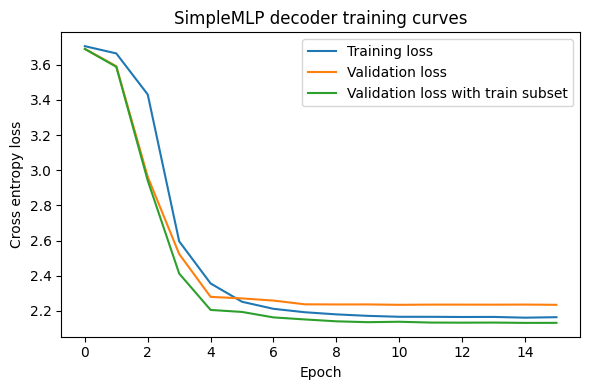

In [29]:
plt.figure(figsize=(6, 4))
plt.plot(MLP_train_loss_per_epoch,    label="Training loss")
plt.plot(MLP_val_loss_per_epoch,     label="Validation loss")
plt.plot(MLP_train_eval_loss_per_epoch,     label="Validation loss with train subset")
plt.xlabel("Epoch")
plt.ylabel("Cross entropy loss")
plt.title("SimpleMLP decoder training curves")
plt.legend()
plt.tight_layout()
plt.savefig("Notebook_result_1/SimpleMLP training.png", bbox_inches='tight')
plt.show()

SimpleMLP_train_result = {"train_loss_per_epoch": MLP_train_loss_per_epoch, "val_loss_per_epoch": MLP_val_loss_per_epoch, "MLP_train_eval_loss_per_epoch":MLP_train_eval_loss_per_epoch}
with open("Notebook_result_1/SimpleMLP_train_result.pickle", "wb") as file:
    pickle.dump(SimpleMLP_train_result, file)

### 3.4.2 GRU decoder training

In [30]:
train_loader = DataLoader(train_data, batch_size=GRU_param["batch_size"], shuffle=True)
val_loader = DataLoader(val_data,   batch_size=GRU_param["batch_size"], shuffle=False)

hyp_param = {
    'hidden_dim': GOLLuM_config["projection_dim"],
    "middle_layer": GRU_param["middle_layer"],
    "hg_growth_factor": GRU_param["hg_growth_factor"],
    "activation": "tanh",
    "dropout_rate_mid": GRU_param["dropout_rate_mid"],
    "batchnorm_mid": True,
    "MAX_LEN": pad_to_length,
    "NCHARS": V,
    "gru_depth": GRU_param["gru_depth"],
    "recurrent_dim": GRU_param["recurrent_dim"],
    "tgru_dropout": GRU_param["tgru_dropout"],
    "temperature": GRU_param["temperature"],
    "do_tgru": True
}

GRU_decoder = GRU(hyp_param, bos_idx=bos_id).to(config["device"])

GRU_optimizer = build_adamW(model=GRU_decoder,lr=GRU_param["lr"], weight_decay=GRU_param["weight_decay"])
GRU_train_criterion = torch.nn.CrossEntropyLoss(ignore_index=pad_id, reduction="sum")
GRU_eval_criterion = torch.nn.CrossEntropyLoss(ignore_index=pad_id, reduction="sum")

epochs = config["decoder"]["epoch"]
GRU_train_loss_per_epoch = []
GRU_val_loss_per_epoch = []
GRU_train_eval_loss_per_epoch = []

best_state = None
best_val_loss = float("inf")
wait, patience, min_delta = 0, 5, 1e-4

for epoch in range(epochs):
    GRU_decoder.train()
    train_loss_sum = 0.0
    train_token_count = 0

    for batch_X, batch_Y in train_loader:
        batch_X, batch_Y = batch_X.to(config["device"]), batch_Y.to(config["device"])
        targets = batch_Y.argmax(dim=-1).to(config["device"])

        logits = GRU_decoder(batch_X, batch_Y)
        loss = GRU_train_criterion(logits.reshape(-1,V), targets.reshape(-1))
        GRU_optimizer.zero_grad(set_to_none=True)
        nonpad = (targets != pad_id).sum().clamp_min(1)
        (loss / nonpad).backward()
        torch.nn.utils.clip_grad_norm_(GRU_decoder.parameters(), 1.0)
        GRU_optimizer.step()

        train_loss_sum   += loss.item()
        train_token_count += nonpad.item()

    avg_train_loss = train_loss_sum / max(train_token_count, 1)
    GRU_train_loss_per_epoch.append(avg_train_loss)

    GRU_decoder.eval()
    val_loss_sum, train_eval_loss_sum = 0.0, 0.0
    val_token_count, train_eval_token_count = 0, 0
    with torch.no_grad():
        for batch_X, batch_Y in val_loader:
            batch_X, batch_Y = batch_X.to(config["device"]), batch_Y.to(config["device"])
            targets = batch_Y.argmax(dim=-1).to(config["device"])

            logits = GRU_decoder(batch_X, batch_Y)
            loss = GRU_eval_criterion(logits.reshape(-1, V), targets.reshape(-1))

            nonpad = (targets != pad_id).sum().item()
            val_loss_sum += loss.item()
            val_token_count += nonpad

        for batch_X, batch_Y in train_loader:
            batch_X, batch_Y = batch_X.to(config["device"]), batch_Y.to(config["device"])
            targets = batch_Y.argmax(dim=-1).to(config["device"])

            logits = GRU_decoder(batch_X, batch_Y)
            loss = GRU_eval_criterion(logits.reshape(-1,V), targets.reshape(-1))
            nonpad = (targets != pad_id).sum().item()
            train_eval_loss_sum   += loss.item()
            train_eval_token_count += nonpad

    avg_train_eval_loss = train_eval_loss_sum / max(train_eval_token_count, 1)
    GRU_train_eval_loss_per_epoch.append(avg_train_eval_loss)

    avg_val_loss = val_loss_sum / max(val_token_count, 1)
    GRU_val_loss_per_epoch.append(avg_val_loss)

    if best_val_loss - avg_val_loss > min_delta:
        best_val_loss = avg_val_loss
        wait = 0
        best_state = {k: v.detach().cpu().clone() for k, v in GRU_decoder.state_dict().items()}
    else:
        wait += 1
        if wait >= patience:
            if best_state is not None:
                GRU_decoder.load_state_dict(best_state)
            break

    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.4f} - Val Loss: {avg_val_loss:.4f}")

Epoch 1/100 - Train Loss: 3.0915 - Val Loss: 2.4281
Epoch 2/100 - Train Loss: 2.3712 - Val Loss: 2.3066
Epoch 3/100 - Train Loss: 2.2776 - Val Loss: 2.2900
Epoch 4/100 - Train Loss: 2.2405 - Val Loss: 2.2733
Epoch 5/100 - Train Loss: 2.1913 - Val Loss: 2.2518
Epoch 6/100 - Train Loss: 2.1501 - Val Loss: 2.2393
Epoch 7/100 - Train Loss: 2.0994 - Val Loss: 2.2409
Epoch 8/100 - Train Loss: 2.0415 - Val Loss: 2.3228
Epoch 9/100 - Train Loss: 1.9912 - Val Loss: 2.3381
Epoch 10/100 - Train Loss: 1.9482 - Val Loss: 2.3823


In [31]:
GRU_decoder.eval()
torch.save(
    GRU_decoder.state_dict(),
    "GRU_decoder_param.pt"
)

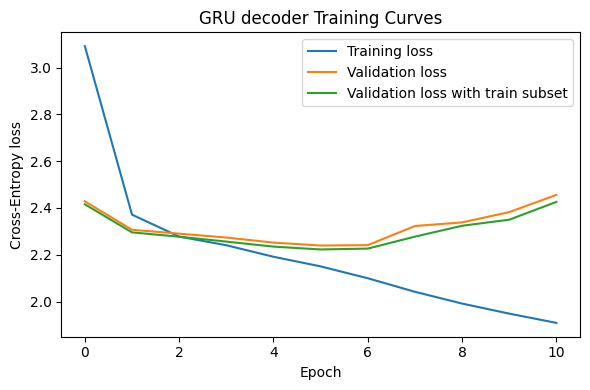

In [32]:
plt.figure(figsize=(6, 4))
plt.plot(GRU_train_loss_per_epoch,    label="Training loss")
plt.plot(GRU_val_loss_per_epoch,     label="Validation loss")
plt.plot(GRU_train_eval_loss_per_epoch,     label="Validation loss with train subset")
plt.xlabel("Epoch")
plt.ylabel("Cross-Entropy loss")
plt.title("GRU decoder Training Curves")
plt.legend()
plt.tight_layout()
plt.savefig("Notebook_result_1/GRU training.png", bbox_inches='tight')
plt.show()

GRU_train_result = {"train_loss_per_epoch": GRU_train_loss_per_epoch, "val_loss_per_epoch": GRU_val_loss_per_epoch, "GRU_train_eval_loss_per_epoch": GRU_train_eval_loss_per_epoch}
with open("Notebook_result_1/GRU_train_result.pickle", "wb") as file:
    pickle.dump(GRU_train_result, file)

### 3.4.3 Vec2Text decoder training

In [33]:
train_loader_ids = DataLoader(train_data_ids, Vec2Text_param["batch_size"], shuffle=True,  drop_last=False)
val_loader_ids = DataLoader(val_data_ids,   Vec2Text_param["batch_size"], shuffle=False, drop_last=False)

Vec2Text_decoder = Vec2Text(
    latent_dim=GOLLuM_config["projection_dim"],
    EmbToSeq_hidden_dim=Vec2Text_param["EmbToSeq_hidden_dim"],
    EmbToSeq_dropout=Vec2Text_param["dropout"],
    num_repeat_tokens=Vec2Text_param["num_repeat_tokens"],
    LoRA_target_proportion=Vec2Text_param["LoRA_target_proportion"],
    LoRA_r=Vec2Text_param["LoRA_r"],
    LoRA_alpha=Vec2Text_param["LoRA_alpha"],
    LoRA_dropout=Vec2Text_param["dropout"],
    model_name=GOLLuM_config["model_name"],
    trainable=GOLLuM_config["trainable"],
    target_ratio=GOLLuM_config["target_ratio"],
    from_top=GOLLuM_config["from_top"],
    lora_dropout=GOLLuM_config["lora_dropout"],
    modules_to_save=GOLLuM_config["modules_to_save"],
    pooling_method=GOLLuM_config["pooling_method"],
    normalize_embeddings=GOLLuM_config["normalize_embeddings"],
    projection_dim = GOLLuM_config["projection_dim"],
    LLMFeaturizer_LoRA_ckpt=LoRA_ckpt,
    LLMFeaturizer_projector_ckpt=projector_ckpt,
    pad_idx_data = pad_id,
    vocab_size = V,
    eos_idx_data = eos_id,
    bos_idx_data = bos_id,
    max_length=config["tokenization"]["max_length"],
    device = config["device"],
    data_type = config["data_type"],
)

base_params = [p for p in Vec2Text_decoder.initial_hypothesis.parameters() if p.requires_grad]
corr_params = list(Vec2Text_decoder.real_Emb2Seq.parameters()) \
            + list(Vec2Text_decoder.difference_Emb2Seq.parameters()) \
            + list(Vec2Text_decoder.predict_Emb2Seq.parameters()) \
            + [p for p in Vec2Text_decoder.corrector.parameters() if p.requires_grad]

base_optimizer = torch.optim.AdamW(base_params, lr=Vec2Text_param["lr"], weight_decay=Vec2Text_param["weight_decay"])
corr_optimizer = torch.optim.AdamW(corr_params, lr=Vec2Text_param["lr"], weight_decay=Vec2Text_param["weight_decay"])

best_val_loss = Vec2Text_decoder.fit(
    train_loader=train_loader_ids,
    val_loader=val_loader_ids,
    base_optimizer=base_optimizer,
    corr_optimizer=corr_optimizer,
    base_epochs=config["decoder"]["epoch"],
    corr_epochs=config["decoder"]["epoch"],
    corr_batch_size=Vec2Text_param["batch_size"],
    pad_idx_data=pad_id,
    weight=None,
    train_eval=True
)


Found 32 linear layers (top 25.0% of 6 layers):
Layer numbers selected: [4, 5]
[LoRA] Using 12 q/v modules. Example(s): ['encoder.block.4.layer.0.SelfAttention.q', 'encoder.block.4.layer.0.SelfAttention.v', 'encoder.block.5.layer.0.SelfAttention.q', 'encoder.block.5.layer.0.SelfAttention.v', 'decoder.block.4.layer.0.SelfAttention.q', 'decoder.block.4.layer.0.SelfAttention.v']

Found 32 linear layers (top 25.0% of 6 layers):
Layer numbers selected: [4, 5]
[LoRA] Using 12 q/v modules. Example(s): ['encoder.block.4.layer.0.SelfAttention.q', 'encoder.block.4.layer.0.SelfAttention.v', 'encoder.block.5.layer.0.SelfAttention.q', 'encoder.block.5.layer.0.SelfAttention.v', 'decoder.block.4.layer.0.SelfAttention.q', 'decoder.block.4.layer.0.SelfAttention.v']
T5-base for LLM
LLM using device: cuda

Found 18 linear layers (top 25.0% of 12 layers):
Layer numbers selected: [9, 10, 11]
trainable params: 165,888 || all params: 109,794,432 || trainable%: 0.1511


Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


[Initial Hypothesis] Epoch 1/100 — Train CE: 6.6308 — Val CE: 5.4870
[Initial Hypothesis] Epoch 2/100 — Train CE: 6.1340 — Val CE: 4.8905
[Initial Hypothesis] Epoch 3/100 — Train CE: 5.5236 — Val CE: 4.3608
[Initial Hypothesis] Epoch 4/100 — Train CE: 4.9996 — Val CE: 3.8364
[Initial Hypothesis] Epoch 5/100 — Train CE: 4.4998 — Val CE: 3.7120
[Initial Hypothesis] Epoch 6/100 — Train CE: 4.1176 — Val CE: 3.4489
[Initial Hypothesis] Epoch 7/100 — Train CE: 3.7495 — Val CE: 3.1775
[Initial Hypothesis] Epoch 8/100 — Train CE: 3.4168 — Val CE: 2.8810
[Initial Hypothesis] Epoch 9/100 — Train CE: 3.1458 — Val CE: 2.6799
[Initial Hypothesis] Epoch 10/100 — Train CE: 2.9495 — Val CE: 2.5365
[Initial Hypothesis] Epoch 11/100 — Train CE: 2.7954 — Val CE: 2.4463
[Initial Hypothesis] Epoch 12/100 — Train CE: 2.6692 — Val CE: 2.4126
[Initial Hypothesis] Epoch 13/100 — Train CE: 2.6025 — Val CE: 2.3767
[Initial Hypothesis] Epoch 14/100 — Train CE: 2.5465 — Val CE: 2.3617
[Initial Hypothesis] Epoch 15

In [34]:
Vec2Text_decoder.eval()
torch.save(
    Vec2Text_decoder.state_dict(),
    "Vec2Text_decoder_param.pt"
)

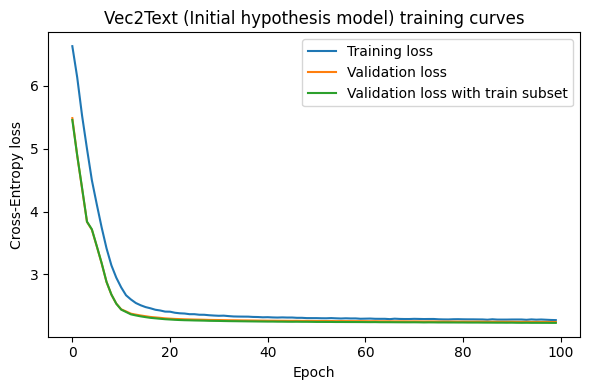

In [35]:
plt.figure(figsize=(6, 4))
plt.plot(Vec2Text_decoder.initial_hypothesis.train_loss_per_epoch,    label="Training loss")
plt.plot(Vec2Text_decoder.initial_hypothesis.val_loss_per_epoch,     label="Validation loss")
plt.plot(Vec2Text_decoder.initial_hypothesis.train_eval_loss_per_epoch,     label="Validation loss with train subset")
plt.xlabel("Epoch")
plt.ylabel("Cross-Entropy loss")
plt.title("Vec2Text (Initial hypothesis model) training curves")
plt.legend()
plt.tight_layout()
plt.savefig("Notebook_result_1/Vec2Text (Initial hypothesis model) training.png", bbox_inches='tight')
plt.show()

V2T_IH_train_result = {
    "train_loss_per_epoch": Vec2Text_decoder.initial_hypothesis.train_loss_per_epoch, 
    "val_loss_per_epoch": Vec2Text_decoder.initial_hypothesis.val_loss_per_epoch, 
    "train_eval_loss_per_epoch":Vec2Text_decoder.initial_hypothesis.train_eval_loss_per_epoch
}
with open("Notebook_result_1/Vec2Text_IH_train_result.pickle", "wb") as file:
    pickle.dump(V2T_IH_train_result, file)

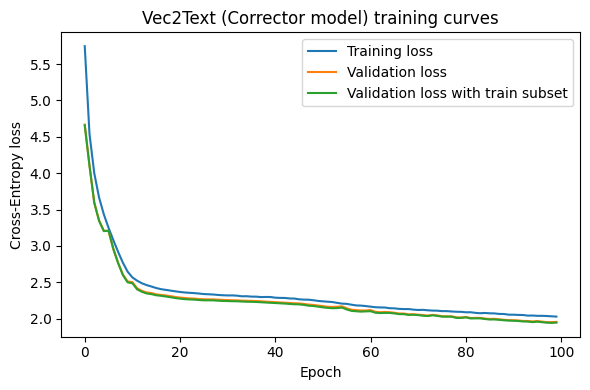

In [36]:
plt.figure(figsize=(6, 4))
plt.plot(Vec2Text_decoder.train_loss_per_epoch,    label="Training loss")
plt.plot(Vec2Text_decoder.val_loss_per_epoch,    label="Validation loss")
plt.plot(Vec2Text_decoder.train_val_loss_per_epoch,    label="Validation loss with train subset")
plt.xlabel("Epoch")
plt.ylabel("Cross-Entropy loss")
plt.title("Vec2Text (Corrector model) training curves")
plt.legend()
plt.tight_layout()
plt.savefig("Notebook_result_1/Vec2Text (Corrector model) training.png", bbox_inches='tight')
plt.show()

V2T_C_train_result = {
    "train_loss_per_epoch": Vec2Text_decoder.train_loss_per_epoch, 
    "val_loss_per_epoch": Vec2Text_decoder.val_loss_per_epoch,
    "train_val_loss_per_epoch": Vec2Text_decoder.train_val_loss_per_epoch
}
with open("Notebook_result_1/Vec2Text_C_train_result.pickle", "wb") as file:
    pickle.dump(V2T_C_train_result, file)

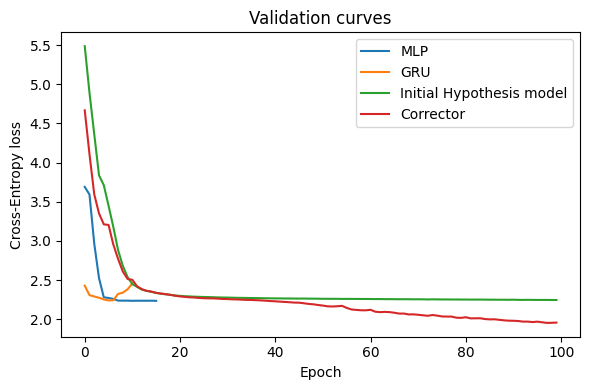

In [37]:
plt.figure(figsize=(6, 4))
plt.plot(MLP_val_loss_per_epoch, label="MLP")
plt.plot(GRU_val_loss_per_epoch, label="GRU")
plt.plot(Vec2Text_decoder.initial_hypothesis.val_loss_per_epoch, label="Initial Hypothesis model")
plt.plot(Vec2Text_decoder.val_loss_per_epoch, label="Corrector")
plt.xlabel("Epoch")
plt.ylabel("Cross-Entropy loss")
plt.title("Validation curves")
plt.legend()
plt.tight_layout()
plt.savefig("Notebook_result_1/Decoder validation.png", bbox_inches='tight')
plt.show()

# 4. Analysis
The analysis of the architecture will be done in following orders:
 1. analysis of GOLLuM Performance
    - analysis of GOLLuM latent embedding structure via PCA for `LogP` and `MolWt`
    - analysis of GOLLuM's performance on `LogP` prediction
 2. analysis of decoder performance
    - analysis of decoder performance of getting exactly correct SELFIES representation for molecule
    - analysis of decoder performance of getting correct SELFIES token on each instances
    - analysis of decoder producing molecule with `LogP` value for the inpur molecule
 3. analysis of molecular design performance of entire architecture
    - analysis of batch one-hot optimization using GOLLuM's GP as fixed priori
    - analysis of using GOLLuM's GP as black-box objective function
    - analysis of using decoder as black-box objective function

To see the model's generality, we produced a new dataframe `analysis_df` using `chembl24_canon_test` such that all molecules here is a new that models have not seen during its training stage.

In [38]:
# cleanning VRAM memory before analysis
torch.cuda.empty_cache()

## 4.1 Data prepatation

In [ ]:
analysis_path = r"data/chembl24_canon_test.smiles"

with open(analysis_path, newline="", encoding="utf-8") as f:
    reader = csv.reader(f) 
    smiles = [row[0].strip() for row in reader if row and row[0].strip()]

unique_smiles = remove_duplicates(smiles)

n = min(config["analysis"]["n_data"], len(unique_smiles))
final_set = get_random_subset(dataset=unique_smiles, subset_size=n, seed=config["seed"])
final_set = [str(x) for x in final_set]

analysis_df = pd.DataFrame(final_set, columns=["SMILES"])
PandasTools.AddMoleculeColumnToFrame(analysis_df, "SMILES", "rdkit_Mol")

analysis_df['SELFIES'] = [selfies.encoder(m) for m in analysis_df['SMILES']]
analysis_df['LogP'] = [Crippen.MolLogP(m) for m in analysis_df['rdkit_Mol']]

As the GOLLuM and decoders are training on fixed vocabulary, we have to filter out those molecules that involves the SELFIES tokens that were not included in the trainind data. This will ensure similar distribution between training, validation, and test dataset.

In [ ]:
from util.util import filter_df_by_vocab
token_to_id_train = vocab_key
analysis_df, dropped_df = filter_df_by_vocab(df=analysis_df, selfies_col="SELFIES", allowed_tokens=vocab_key, keep_debug_cols=False)

print(f"After filltering, the number of molecules for analysis is: {len(analysis_df)}")

with open("Notebook_result_1/analysis_df.pickle", "wb") as file:
    pickle.dump(analysis_df, file)

analysis_df.head()

After filltering, the number of molecules for analysis is: 250


,SMILES,rdkit_Mol,SELFIES,LogP
0,O=C(CCCCCn1c(=S)[nH]c2ccccc2c1=O)N1CCC(O)(c2cc...,<rdkit.Chem.rdchem.Mol object at 0x0000018459E...,[O][=C][Branch2][Ring1][Branch2][C][C][C][C][C...,4.78309
1,S=c1sc(SCCOc2ccccc2)nn1-c1ccccc1,<rdkit.Chem.rdchem.Mol object at 0x0000018459E...,[S][=C][S][C][Branch1][=N][S][C][C][O][C][=C][...,4.83439
2,COC(=O)c1cc(C)nc2c1c(=O)nc(SCc1ccccc1F)n2C1CC1,<rdkit.Chem.rdchem.Mol object at 0x0000018459E...,[C][O][C][=Branch1][C][=O][C][=C][C][Branch1][...,3.65282
3,CC(NC(Cc1ccc(-c2cccc(Cl)c2)cc1)C(=O)NC1=NNNN1C...,<rdkit.Chem.rdchem.Mol object at 0x0000018459E...,[C][C][Branch2][Ring2][=Branch2][N][C][Branch2...,1.32260
4,O=C(O)c1cccc(CN=c2[nH][nH]c(=Nc3cc(Cl)cc(Cl)c3...,<rdkit.Chem.rdchem.Mol object at 0x0000018459E...,[O][=C][Branch1][C][O][C][=C][C][=C][C][Branch...,3.00920


In [41]:
prompts = [make_template(smi) for smi in analysis_df["SMILES"].tolist()]

tokenizer = AutoTokenizer.from_pretrained("t5-base", trust_remote_code=True)
tokenizer.pad_token = tokenizer.pad_token or tokenizer.eos_token

HF_MAX_LEN = gollum_architecture.train_inputs[0].shape[-1] // 2

_token_ids = tokenizer(prompts, padding=False, truncation=False, add_special_tokens=True)["input_ids"]
_max_batch_len = max(len(ids) for ids in _token_ids)

tokenized_smiles = tokenizer(
    prompts,
    padding="max_length" if HF_MAX_LEN > _max_batch_len else config["tokenization"]["padding"],  # "longest"
    truncation=config["tokenization"]["truncation"],
    max_length=HF_MAX_LEN,
    return_tensors=config["tokenization"]["return_tensors"],
)

analysis_x_raw = torch.cat(
    [tokenized_smiles["input_ids"], tokenized_smiles["attention_mask"]], dim=1
)

analysis_x_raw = analysis_x_raw.to(config["device"])

## 4.2 Analysis of GOLLuM performance
### 4.2.1 Latent Space visualization and checking GOLLuM latent space performance
Via PCA, we reduced the 64 dimension latent embedding coordinates to 2 dimensional space. <br>
Then, we plot molecular weight (`Molwt`) and `LogP` value via colour coding on the 2 dimensional scatter plot, to check what is the trend that the GOLLuM architecture learnt.<br>
`MolWt` cannot be a true molecular descriptor to tell if the molecules in the embedding space have structural similarities next to each others. However, we believe that dramatic changes of molecular structure (such as change of functional group) will mostly lead to dramatic change of molecular weight, while the change of a few atoms will lead to only a subtle changes. Thus, for visaulization purpose, we used `MolWt` as an indicator for change of molecular structure.

In [42]:
encoder.eval()
analysis_embeddings=encoder(analysis_x_raw).detach().cpu().numpy()
analysis_df["SMILES_embed"] = list(analysis_embeddings)

In [43]:
smiless_embed = np.stack(analysis_df["SMILES_embed"].to_numpy())
scaled_embed = StandardScaler().fit_transform(smiless_embed)
pca = PCA(n_components=2, random_state=0)
Z = pca.fit_transform(scaled_embed)
analysis_df[["PC1", "PC2"]] = Z

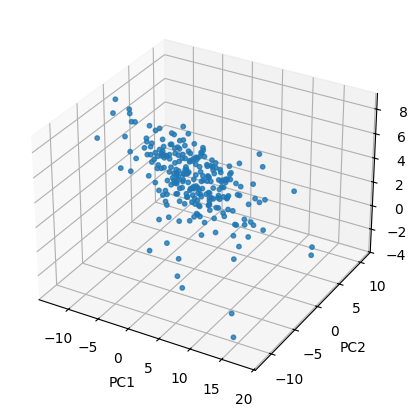

In [44]:
fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(analysis_df["PC1"], analysis_df["PC2"], analysis_df["LogP"], s=10, alpha=0.8)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("LogP[-]")
plt.show()

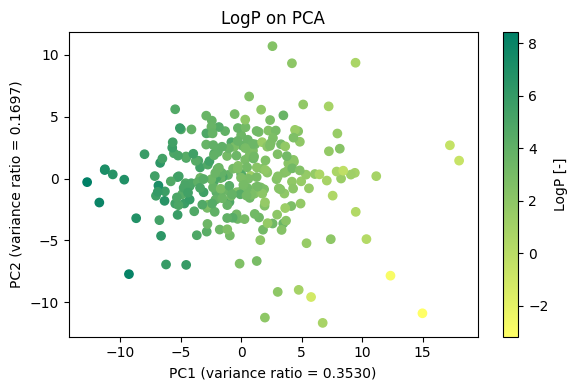

In [45]:
plt.figure(figsize=(6, 4))
plt.scatter(analysis_df["PC1"], analysis_df["PC2"], c=analysis_df["LogP"], cmap="summer_r")
plt.colorbar(label="LogP [-]")
plt.xlabel(f"PC1 (variance ratio = {pca.explained_variance_ratio_[0]:.4f})")
plt.ylabel(f"PC2 (variance ratio = {pca.explained_variance_ratio_[1]:.4f})")
plt.title("LogP on PCA")
plt.tight_layout()
plt.savefig("Notebook_result_1/LogP on PCA.png", bbox_inches="tight")
plt.show()

LogP_on_PCA = {"PC1": analysis_df["PC1"], "PC2": analysis_df["PC2"], "LogP": analysis_df["LogP"]}
with open("Notebook_result_1/LogP_on_PCA.pickle", "wb") as file:
    pickle.dump(LogP_on_PCA, file)

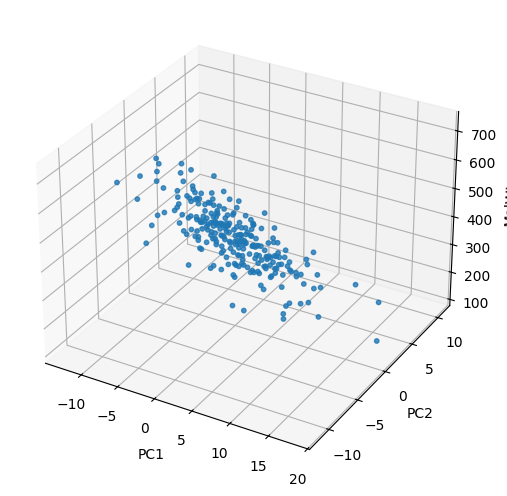

In [46]:
analysis_df["MolWt"] = [Descriptors.MolWt(s) for s in analysis_df["rdkit_Mol"]]

fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(analysis_df["PC1"], analysis_df["PC2"], analysis_df["MolWt"], s=10, alpha=0.8)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("MolWt")
plt.tight_layout()
plt.show()

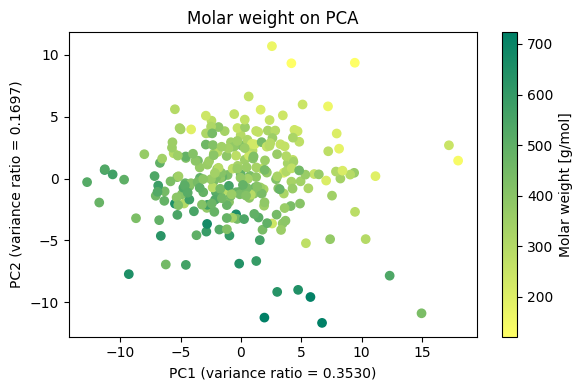

In [47]:
plt.figure(figsize=(6, 4))
plt.scatter(analysis_df["PC1"], analysis_df["PC2"], c=analysis_df["MolWt"], cmap="summer_r")
plt.colorbar(label="Molar weight [g/mol]")
plt.xlabel(f"PC1 (variance ratio = {pca.explained_variance_ratio_[0]:.4f})")
plt.ylabel(f"PC2 (variance ratio = {pca.explained_variance_ratio_[1]:.4f})")
plt.title("Molar weight on PCA")
plt.tight_layout()
plt.savefig("Notebook_result_1/MolWt on PCA.png", bbox_inches="tight")
plt.show()

MolWt_on_PCA = {"PC1": analysis_df["PC1"], "PC2": analysis_df["PC2"], "MolWt": analysis_df["MolWt"]}
with open("Notebook_result_1/MolWt_on_PCA.pickle", "wb") as file:
    pickle.dump(MolWt_on_PCA, file)

### 4.2.2 Property prediction of GOLLuM architecture
Calculating mean squared error between the rdkit predicted `LogP` value and GOLLuM predicted `LogP`.<br>
Since the GP is probabilistic model that returns both mean and standard deviation, we can use chi-squared test for goodness-of-fit-test.

In [48]:
analysis_x_raw = torch.as_tensor(analysis_x_raw, device=gollum_architecture.device)

In [49]:
print(analysis_x_raw[0].shape)
print(gollum_architecture.train_inputs[0].shape[-1])

torch.Size([204])
204


In [50]:
gollum_architecture.eval()
mean, var = gollum_architecture.predict(x=analysis_x_raw, observation_noise=True, return_var=True, return_posterior=False)
mean = mean.squeeze(-1).detach().cpu()
std  = var.clamp_min(0).sqrt().squeeze(-1).detach().cpu()

true = np.array(analysis_df["LogP"])
property_mse = mean_squared_error(true, mean)
print(property_mse) 

with open("Notebook_result_1/Property prediction of GOLLuM.txt", "w") as file:
    file.write(f"The Mean Square Error of GOLLuM LogP prediction is {property_mse}")

0.35315434821350883


## 4.3 Performance measure of Decoders
As we already computed the SELFIES string of the input data, we will quantify the performance of the decoder based on the 3 criteria:
 1. Whether the decoded string is exactly match with the input molecule (`perfect-match` measured in percentage)
 2. to what extend the decoder can give us correct label at each sequence-step (`token-match` measured in percentage)
 3. to what extent the decoded molecule will give similar property prediction to the GOLLuM predicted and input value.

### 4.3.1 Data preparation
Since `encoder` is already initiated during Section 3.1 as `LLMFeaturizer` with its parameters reloaded, we will use it directly.

In [51]:
from util.decoder_util import convert_to_string

In [52]:
X_analysis = np.stack(analysis_df["SMILES_embed"].to_numpy())
X = torch.from_numpy(X_analysis).to(device=config["device"], dtype=config["data_type"])

In [53]:
MLP_decoder.eval()
with torch.no_grad():
    MLP_recon = MLP_decoder(X)
MLP_selfies = convert_to_string(data=MLP_recon, id_to_token=int_key, to_smiles=False, input_data_type="one-hot")
MLP_smiles = convert_to_string(data=MLP_recon, id_to_token=int_key, to_smiles=True, input_data_type="one-hot")
MLP_mols = [MolFromSmiles(s) for s in MLP_smiles]

In [54]:
GRU_decoder.eval()
with torch.no_grad():
    GRU_recon = GRU_decoder(X)
GRU_selfies = convert_to_string(data=GRU_recon, id_to_token=int_key, to_smiles=False, input_data_type="one-hot")
GRU_smiles = convert_to_string(data=GRU_recon, id_to_token=int_key, to_smiles=True, input_data_type="one-hot")
GRU_mols = [MolFromSmiles(s) for s in GRU_smiles]

In [55]:
Vec2Text_decoder.eval()
with torch.no_grad():
    Vec2Text_recon = Vec2Text_decoder(max_loop=config["decoder"]["max_loop"], latent_emb=X, true_emb=X, early_stop_tol=config["decoder"]["early_stop_tol"], patience=config["decoder"]["patience"])
Vec2Text_selfies = convert_to_string(data=Vec2Text_recon, id_to_token=int_key, to_smiles=False, input_data_type="label")
print("SELFIES conversion done.")
Vec2Text_smiles = convert_to_string(data=Vec2Text_recon, id_to_token=int_key, to_smiles=True, input_data_type="label")
print("SMILES conversion done.")
Vec2Text_mols = [MolFromSmiles(s) for s in Vec2Text_smiles]

SELFIES conversion done.
SMILES conversion done.


In [56]:
decoder_reconstruction_result = {
    "MLP_selfies": MLP_selfies,
    "MLP_smiles": MLP_smiles,
    "MLP_mols": MLP_mols,
    "GRU_selfies": GRU_selfies,
    "GRU_smiles": GRU_smiles,
    "GRU_mols": GRU_mols,
    "Vec2Text_selfies": Vec2Text_selfies,
    "Vec2Text_smiles": Vec2Text_smiles,
    "Vec2Text_mols": Vec2Text_mols
}
with open("Notebook_result_1/decoder_reconstruction_result.pickle", "wb") as file:
    pickle.dump(decoder_reconstruction_result, file)

### 4.3.2 Perfect-match score
This analysis will focus on how many molecules did the decoder actually got the perfectly matching molecules using RDKit registration hash.

In [57]:
from util.util import same_molecule_hash
original_mol = analysis_df["rdkit_Mol"].tolist()

In [58]:
MLP_count, GRU_count, V2T_count = 0, 0, 0
for i in range(len(X)):
    MLP_TF = same_molecule_hash(original_mol[i], MLP_mols[i])
    GRU_TF = same_molecule_hash(original_mol[i], GRU_mols[i])
    V2T_TF = same_molecule_hash(original_mol[i], Vec2Text_mols[i])
    MLP_count += 1 if MLP_TF is True else 0
    GRU_count += 1 if GRU_TF is True else 0
    V2T_count += 1 if V2T_TF is True else 0

print(f"MLP got correct molecules for {MLP_count} \nGRU got correct molecules for {GRU_count} \nVec2Text got correct molecules for {V2T_count}")

with open("Notebook_result_1/Decoder analysis.txt", "w") as file:
    file.write("Perfect match\n")
    file.write(f"MLP got correct molecules for {MLP_count} \nGRU got correct molecules for {GRU_count} \nVec2Text got correct molecules for {V2T_count} \n")

MLP got correct molecules for 0 
GRU got correct molecules for 0 
Vec2Text got correct molecules for 0


### 4.3.3 Token-match score
this analysis will focus on individual token match.

In [59]:
SPECIAL_TOKENS_DEFAULT = {"[bos]", "[eos]", "[nop]"}

In [60]:
from util.util import token_match_scores

gt_selfies = analysis_df["SELFIES"].tolist()

micro_MLP, macro_MLP, tbl_MLP = token_match_scores(gt_selfies, MLP_selfies, special_tokens=SPECIAL_TOKENS_DEFAULT)

print(f"MLP Token-match (micro): {micro_MLP*100:.2f}%")
print(f"MLP Token-match (macro): {macro_MLP*100:.2f}%")

with open("Notebook_result_1/Decoder analysis.txt", "a") as file:
    file.write("\nToken-mathc\n")
    file.write(f"MLP Token-match (micro): {micro_MLP*100:.6f}%\n")
    file.write(f"MLP Token-match (macro): {macro_MLP*100:.6f}%\n")

MLP Token-match (micro): 37.63%
MLP Token-match (macro): 37.64%


In [61]:
micro_GRU, macro_GRU, tbl_GRU = token_match_scores(gt_selfies, GRU_selfies, special_tokens=SPECIAL_TOKENS_DEFAULT)

print(f"GRU Token-match (micro): {micro_GRU*100:.2f}%")
print(f"GRU Token-match (macro): {macro_GRU*100:.2f}%")

with open("Notebook_result_1/Decoder analysis.txt", "a") as file:
    file.write(f"GRU Token-match (micro): {micro_GRU*100:.6f}%\n")
    file.write(f"GRU Token-match (macro): {macro_GRU*100:.6f}%\n")

GRU Token-match (micro): 37.85%
GRU Token-match (macro): 37.76%


In [62]:
micro_V2T, macro_V2T, tbl_V2T = token_match_scores(gt_selfies, Vec2Text_selfies, special_tokens=SPECIAL_TOKENS_DEFAULT)

print(f"Vec2Text Token-match (micro): {micro_V2T*100:.2f}%")
print(f"Vec2Text Token-match (macro): {macro_V2T*100:.2f}%")

with open("Notebook_result_1/Decoder analysis.txt", "a") as file:
    file.write(f"Vec2Text Token-match (micro): {micro_V2T*100:.6f}%\n")
    file.write(f"Vec2Text Token-match (macro): {macro_V2T*100:.6f}%\n")

Vec2Text Token-match (micro): 20.19%
Vec2Text Token-match (macro): 20.46%


### 4.3.4 Property-match
The purpose of this analysis is, although the decoder performance for the getting the string molecular representation was low, can it at least give the molecule with similar property that the embedding should have. <br>
We first create a prompts from the SMILES string prediction, and predict the property of the predicted and compare with actual using MSE loss function.

In [63]:
from util.util import safe_logp

MLP_LogP = [safe_logp(mol) for mol in MLP_smiles]
GRU_LogP = [safe_logp(mol) for mol in GRU_smiles]
Vec2Text_LogP = [safe_logp(mol) for mol in Vec2Text_smiles]

In [64]:
MLP_mse = mean_squared_error(true, MLP_LogP)
GRU_mse = mean_squared_error(true, GRU_LogP)
V2T_mse = mean_squared_error(true, Vec2Text_LogP)
print(f"MSE for MLP decoded SMILES strings are {MLP_mse}")
print(f"MSE for GRU decoded SMILES strings are {GRU_mse}")
print(f"MSE for Vec2Text decoded SMILES strings are {V2T_mse}")

with open("Notebook_result_1/Decoder analysis.txt", "a") as file:
    file.write("\nProperty-match\n")
    file.write(f"MSE for MLP decoded SMILES strings are {MLP_mse}\n")
    file.write(f"MSE for GRU decoded SMILES strings are {GRU_mse}\n")
    file.write(f"MSE for Vec2Text decoded SMILES strings are {V2T_mse}\n")

MSE for MLP decoded SMILES strings are 528.8125136736647
MSE for GRU decoded SMILES strings are 1289.128345364742
MSE for Vec2Text decoded SMILES strings are 612.2118788812904


## 4.4 Optimization Performance

The DeepGP class had been modified with `_latent_view` and `opt_from_embed` functions so that a batch one-hot Bayesian optimization can be applied on the latent embeding to the GP surrogate model. <br>

There are 3 optimization strategy that we want to examine:
 1. using the DeepGP's GP surrogate model as a final posteriori, we can apply acquisition function on it (`qEcpectedImprovement`) and set `q>1` such that, the `botorch` will sample `q` point of sample to explore via fantasies. Via this, we can examine, can we use DeepGP's GP surrogate model soley for molecular deisng, without updating using decoder when the decoder performance is poor. The analysis of the performance of the optimization algorithm will be quantified comparison of the `LogP` value that the mebedding produces compared to the distribution of training data.
 2. using the DeepGP's GP surrogate model as a black-box objective function, we can build a fresh prior GP from sampling on the latent embedding (Basically, this will be Bayeian optimization GP trying to mimic the DeepGP's GP). Since DeepGP's GP is objective function, the priori and posterior will get updated via DeepGP's GP. Then, we will examine how well did the decoder molecules have followed the optimization trend. Essentially, purpose of this analysis is to see if "GOLLuM + decoder" will be good for molecular design (this is how Gomez-Bombarelli did his molecular deisgn).
 3. using the decoder+RDkit as the black-box objective function, we can build another fresh prior GP from sampling on the latent embedding. This analysis will focus on whether using the decoder as the only black-box is good enough after sufficient training of DeepGP and decoder.


### 4.4.1 Batch one-shot optimization using fantasies

In [65]:
train_min, train_max= train_df["LogP"].min(), train_df["LogP"].max()
step = (train_max - train_min)/19
print(train_min, train_max, step)

-4.712699999999988 11.810399999999985 0.8696368421052618


(array([  2.,   1.,   1.,   6.,   9.,  20.,  43.,  90., 147., 137., 140.,
         87.,  35.,  22.,   5.,   2.,   1.,   0.,   2.]),
 array([-4.7127    , -3.84306316, -2.97342632, -2.10378947, -1.23415263,
        -0.36451579,  0.50512105,  1.37475789,  2.24439474,  3.11403158,
         3.98366842,  4.85330526,  5.72294211,  6.59257895,  7.46221579,
         8.33185263,  9.20148947, 10.07112632, 10.94076316, 11.8104    ]),
 <BarContainer object of 19 artists>)

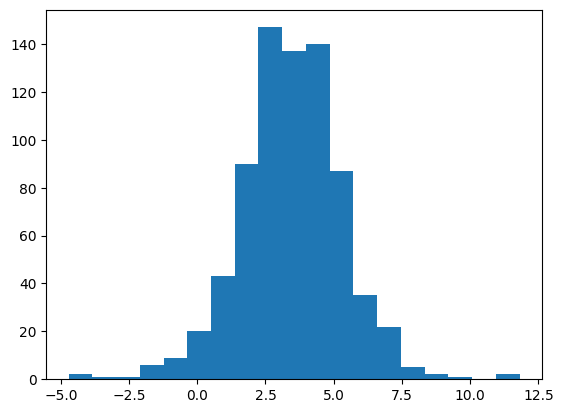

In [66]:
plt.hist(train_df["LogP"].to_numpy(), bins=np.arange(train_min, train_max+step, step).tolist())

In [67]:
candidates = gollum_architecture.opt_from_embed(q = config["analysis"]["q"],
                                            maximize = True,
                                            pad_frac = 0.2,
                                            num_restarts = config["analysis"]["num_restarts"],
                                            raw_samples = config["analysis"]["raw_samples"],
                                            sampler_n = config["analysis"]["sampler_n"],
                                            )

c:\Users\mccha\miniconda3\envs\FYP\Lib\site-packages\botorch\acquisition\monte_carlo.py:396: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
c:\Users\mccha\miniconda3\envs\FYP\Lib\site-packages\botorch\optim\optimize.py:331: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  generated_initial_conditions = opt_inputs.get_ic_generator()(


Assuming that the distribution of `LogP` follows normal distribution, we will examine, cumulative probability of optimized molecule's property is.

In [68]:
mean, std = np.mean(train_df["LogP"]), np.std(train_df["LogP"])

In [69]:
GP_latent = gollum_architecture._latent_view()
post = GP_latent.posterior(candidates)
result = post.mean.detach().cpu().numpy()
print(result)

[[ 2.53808813]
 [ 3.38025774]
 [ 5.23905685]
 [ 2.92502926]
 [ 0.63031388]
 [ 4.18231959]
 [ 3.09727069]
 [ 1.74053783]
 [ 2.49529016]
 [ 2.73104108]
 [ 3.81084607]
 [-0.01471973]
 [ 3.30693894]
 [ 2.07953073]
 [ 4.72417503]]


In [70]:
def function(x, std=std, mean=mean):
    return (1/(math.sqrt(np.pi*2)*std)) * np.exp(-0.5*((x-mean)/std)**2)
I=[]
for i in range(len(result)):
    I.append(quad(function, train_min, result[i]))
print(I)

with open("Notebook_result_1/Batch one-hot optimization with fantasies.txt", "w") as file:
    file.write("\n".join(map(str, I)))
with open("Notebook_result_1/Batch_one_hot_optim.pickle", "wb") as file:
    pickle.dump(I, file)

[(0.3103543732030984, 4.287694094986135e-13), (0.4827962717507994, 3.3789406921043886e-11), (0.8299185591524527, 9.020574739160348e-09), (0.3869396117896878, 4.5403048612637825e-12), (0.06449045561283237, 7.159878868993315e-16), (0.6506431368202577, 2.341811053668487e-10), (0.4227276313793997, 1.0471934299747098e-11), (0.17810071028004837, 1.0299005173274499e-14), (0.30229838516239455, 3.0948814305556715e-13), (0.3477682329411248, 1.5437184766909641e-12), (0.574488810290265, 1.2878180146836007e-10), (0.031150957683499264, 3.4584510459344814e-16), (0.4671396037004743, 2.551163539190938e-11), (0.22940692025844772, 2.5469284487927593e-15), (0.7510143576589574, 9.666269032927033e-11)]


### 4.4.2 Using DeepGP's GP as objective function

No. of optimization run: 0
No. of optimization run: 1
No. of optimization run: 2
No. of optimization run: 3
No. of optimization run: 4
No. of optimization run: 5
No. of optimization run: 6
No. of optimization run: 7
No. of optimization run: 8
No. of optimization run: 9
No. of optimization run: 10
No. of optimization run: 11
No. of optimization run: 12
No. of optimization run: 13
No. of optimization run: 14
No. of optimization run: 15
No. of optimization run: 16
No. of optimization run: 17
No. of optimization run: 18
No. of optimization run: 19
No. of optimization run: 20
No. of optimization run: 21
No. of optimization run: 22
No. of optimization run: 23
No. of optimization run: 24
No. of optimization run: 25
No. of optimization run: 26
No. of optimization run: 27
No. of optimization run: 28
No. of optimization run: 29
No. of optimization run: 30
No. of optimization run: 31
No. of optimization run: 32
No. of optimization run: 33
No. of optimization run: 34
No. of optimization run: 35
No

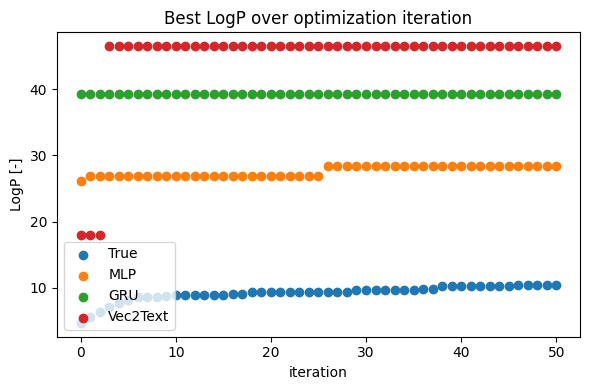

In [71]:
from optimization.Approach1 import GPbased_optimizer
true_list, MLP_list, GRU_list, V2T_list, iter_count = GPbased_optimizer(DeepGP=gollum_architecture, SimpleMLP=MLP_decoder, GRU=GRU_decoder, Vec2Text=Vec2Text_decoder, train_embed_data=train_df["SMILES_embed"], int_key=int_key, max_loop=config["decoder"]["max_loop"], early_stop_tol=config["decoder"]["early_stop_tol"], patience=config["decoder"]["patience"], iter_budget=config["analysis"]["iter_budget"], initial_sample_num=config["analysis"]["initial_sample_num"], projection_dim=GOLLuM_config["projection_dim"], num_restarts=config["analysis"]["num_restarts"], raw_samples=config["analysis"]["raw_samples"], seed=config["seed"])

GP_objfunc = {"ture_list": true_list, "MLP_list": MLP_list, "GRU_list":GRU_list, "V2T_list":V2T_list, "iter_count": iter_count}
with open("Notebook_result_1/BO_GP_objfunc.pickle", "wb") as file:
    pickle.dump(GP_objfunc, file)

plt.figure(figsize=(6, 4))
plt.scatter(iter_count, true_list, label="True")
plt.scatter(iter_count, MLP_list, label="MLP")
plt.scatter(iter_count, GRU_list, label="GRU")
plt.scatter(iter_count, V2T_list, label="Vec2Text")
plt.legend()
plt.xlabel("iteration")
plt.ylabel("LogP [-]")
plt.title("Best LogP over optimization iteration")
plt.tight_layout()
plt.savefig("Notebook_result_1/GP as objective function.png", bbox_inches="tight")
plt.show()

### 4.4.3 Using decoders as objective funciton

No. of optimization run: 0
No. of optimization run: 1
No. of optimization run: 2
No. of optimization run: 3
No. of optimization run: 4
No. of optimization run: 5
No. of optimization run: 6
No. of optimization run: 7
No. of optimization run: 8
No. of optimization run: 9
No. of optimization run: 10
No. of optimization run: 11
No. of optimization run: 12
No. of optimization run: 13
No. of optimization run: 14
No. of optimization run: 15
No. of optimization run: 16
No. of optimization run: 17
No. of optimization run: 18
No. of optimization run: 19
No. of optimization run: 20
No. of optimization run: 21
No. of optimization run: 22
No. of optimization run: 23
No. of optimization run: 24
No. of optimization run: 25
No. of optimization run: 26
No. of optimization run: 27
No. of optimization run: 28
No. of optimization run: 29
No. of optimization run: 30
No. of optimization run: 31
No. of optimization run: 32
No. of optimization run: 33
No. of optimization run: 34
No. of optimization run: 35
No

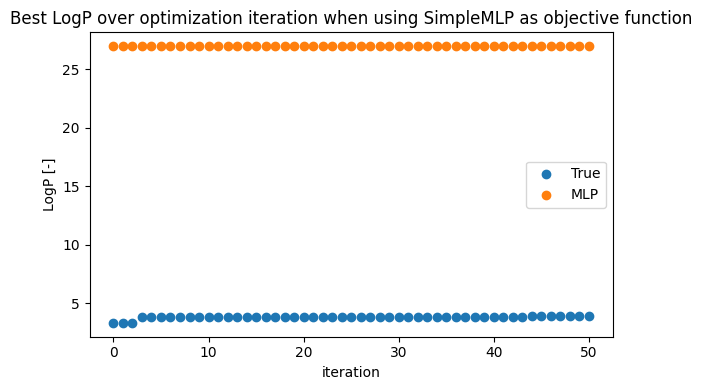

In [ ]:
from optimization.Approach2 import decoderbased_optimizer
true_list, MLP_list, iter_count = decoderbased_optimizer(DeepGP=gollum_architecture, decoder=MLP_decoder, train_embed_data=train_df["SMILES_embed"], int_key=int_key, iter_budget=config["analysis"]["iter_budget"], initial_sample_num=config["analysis"]["initial_sample_num"], projection_dim=GOLLuM_config["projection_dim"], num_restarts=config["analysis"]["num_restarts"], raw_samples=config["analysis"]["raw_samples"], seed=config["seed"])

true_list = np.asarray([t.detach().cpu().item() if torch.is_tensor(t) else float(t) for t in true_list])
MLP_list = np.asarray([t.detach().cpu().item() if torch.is_tensor(t) else float(t)for t in MLP_list])
iter_count = np.asarray(iter_count)

MLP_objfunc = {"true_list":true_list, "MLP_list":MLP_list, "iter_count":iter_count}
with open("Notebook_result_1/BO_MLP_objfunc.pickle", "wb") as file:
    pickle.dump(MLP_objfunc, file)

plt.figure(figsize=(6, 4))
plt.scatter(iter_count, true_list, label="True")
plt.scatter(iter_count, MLP_list, label="MLP")
plt.legend()
plt.xlabel("iteration")
plt.ylabel("LogP [-]")
plt.title("Best LogP over optimization iteration when using SimpleMLP as objective function")
plt.tight_layout()
plt.savefig("Notebook_result_1/MLP as objective function.png", bbox_inches="tight")
plt.show()

No. of optimization run: 0


c:\Users\mccha\miniconda3\envs\FYP\Lib\site-packages\botorch\models\utils\assorted.py:273: InputDataWarning: Data (outcome observations) is not standardized (std = tensor([0.], device='cuda:0', dtype=torch.float64), mean = tensor([0.], device='cuda:0', dtype=torch.float64)).Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No. of optimization run: 1


c:\Users\mccha\miniconda3\envs\FYP\Lib\site-packages\botorch\models\utils\assorted.py:273: InputDataWarning: Data (outcome observations) is not standardized (std = tensor([0.], device='cuda:0', dtype=torch.float64), mean = tensor([0.], device='cuda:0', dtype=torch.float64)).Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No. of optimization run: 2


c:\Users\mccha\miniconda3\envs\FYP\Lib\site-packages\botorch\models\utils\assorted.py:273: InputDataWarning: Data (outcome observations) is not standardized (std = tensor([0.], device='cuda:0', dtype=torch.float64), mean = tensor([0.], device='cuda:0', dtype=torch.float64)).Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No. of optimization run: 3


c:\Users\mccha\miniconda3\envs\FYP\Lib\site-packages\botorch\models\utils\assorted.py:273: InputDataWarning: Data (outcome observations) is not standardized (std = tensor([0.], device='cuda:0', dtype=torch.float64), mean = tensor([0.], device='cuda:0', dtype=torch.float64)).Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No. of optimization run: 4


c:\Users\mccha\miniconda3\envs\FYP\Lib\site-packages\botorch\models\utils\assorted.py:273: InputDataWarning: Data (outcome observations) is not standardized (std = tensor([0.], device='cuda:0', dtype=torch.float64), mean = tensor([0.], device='cuda:0', dtype=torch.float64)).Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No. of optimization run: 5


c:\Users\mccha\miniconda3\envs\FYP\Lib\site-packages\botorch\models\utils\assorted.py:273: InputDataWarning: Data (outcome observations) is not standardized (std = tensor([0.], device='cuda:0', dtype=torch.float64), mean = tensor([0.], device='cuda:0', dtype=torch.float64)).Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No. of optimization run: 6


c:\Users\mccha\miniconda3\envs\FYP\Lib\site-packages\botorch\models\utils\assorted.py:273: InputDataWarning: Data (outcome observations) is not standardized (std = tensor([0.], device='cuda:0', dtype=torch.float64), mean = tensor([0.], device='cuda:0', dtype=torch.float64)).Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No. of optimization run: 7


c:\Users\mccha\miniconda3\envs\FYP\Lib\site-packages\botorch\models\utils\assorted.py:273: InputDataWarning: Data (outcome observations) is not standardized (std = tensor([0.], device='cuda:0', dtype=torch.float64), mean = tensor([0.], device='cuda:0', dtype=torch.float64)).Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No. of optimization run: 8


c:\Users\mccha\miniconda3\envs\FYP\Lib\site-packages\botorch\models\utils\assorted.py:273: InputDataWarning: Data (outcome observations) is not standardized (std = tensor([0.], device='cuda:0', dtype=torch.float64), mean = tensor([0.], device='cuda:0', dtype=torch.float64)).Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No. of optimization run: 9


c:\Users\mccha\miniconda3\envs\FYP\Lib\site-packages\botorch\models\utils\assorted.py:273: InputDataWarning: Data (outcome observations) is not standardized (std = tensor([0.], device='cuda:0', dtype=torch.float64), mean = tensor([0.], device='cuda:0', dtype=torch.float64)).Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No. of optimization run: 10


c:\Users\mccha\miniconda3\envs\FYP\Lib\site-packages\botorch\models\utils\assorted.py:273: InputDataWarning: Data (outcome observations) is not standardized (std = tensor([0.], device='cuda:0', dtype=torch.float64), mean = tensor([0.], device='cuda:0', dtype=torch.float64)).Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No. of optimization run: 11


c:\Users\mccha\miniconda3\envs\FYP\Lib\site-packages\botorch\models\utils\assorted.py:273: InputDataWarning: Data (outcome observations) is not standardized (std = tensor([0.], device='cuda:0', dtype=torch.float64), mean = tensor([0.], device='cuda:0', dtype=torch.float64)).Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No. of optimization run: 12


c:\Users\mccha\miniconda3\envs\FYP\Lib\site-packages\botorch\models\utils\assorted.py:273: InputDataWarning: Data (outcome observations) is not standardized (std = tensor([0.], device='cuda:0', dtype=torch.float64), mean = tensor([0.], device='cuda:0', dtype=torch.float64)).Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No. of optimization run: 13


c:\Users\mccha\miniconda3\envs\FYP\Lib\site-packages\botorch\models\utils\assorted.py:273: InputDataWarning: Data (outcome observations) is not standardized (std = tensor([0.], device='cuda:0', dtype=torch.float64), mean = tensor([0.], device='cuda:0', dtype=torch.float64)).Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No. of optimization run: 14


c:\Users\mccha\miniconda3\envs\FYP\Lib\site-packages\botorch\models\utils\assorted.py:273: InputDataWarning: Data (outcome observations) is not standardized (std = tensor([0.], device='cuda:0', dtype=torch.float64), mean = tensor([0.], device='cuda:0', dtype=torch.float64)).Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No. of optimization run: 15


c:\Users\mccha\miniconda3\envs\FYP\Lib\site-packages\botorch\models\utils\assorted.py:273: InputDataWarning: Data (outcome observations) is not standardized (std = tensor([0.], device='cuda:0', dtype=torch.float64), mean = tensor([0.], device='cuda:0', dtype=torch.float64)).Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No. of optimization run: 16


c:\Users\mccha\miniconda3\envs\FYP\Lib\site-packages\botorch\models\utils\assorted.py:273: InputDataWarning: Data (outcome observations) is not standardized (std = tensor([0.], device='cuda:0', dtype=torch.float64), mean = tensor([0.], device='cuda:0', dtype=torch.float64)).Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No. of optimization run: 17


c:\Users\mccha\miniconda3\envs\FYP\Lib\site-packages\botorch\models\utils\assorted.py:273: InputDataWarning: Data (outcome observations) is not standardized (std = tensor([0.], device='cuda:0', dtype=torch.float64), mean = tensor([0.], device='cuda:0', dtype=torch.float64)).Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No. of optimization run: 18


c:\Users\mccha\miniconda3\envs\FYP\Lib\site-packages\botorch\models\utils\assorted.py:273: InputDataWarning: Data (outcome observations) is not standardized (std = tensor([0.], device='cuda:0', dtype=torch.float64), mean = tensor([0.], device='cuda:0', dtype=torch.float64)).Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No. of optimization run: 19


c:\Users\mccha\miniconda3\envs\FYP\Lib\site-packages\botorch\models\utils\assorted.py:273: InputDataWarning: Data (outcome observations) is not standardized (std = tensor([0.], device='cuda:0', dtype=torch.float64), mean = tensor([0.], device='cuda:0', dtype=torch.float64)).Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No. of optimization run: 20


c:\Users\mccha\miniconda3\envs\FYP\Lib\site-packages\botorch\models\utils\assorted.py:273: InputDataWarning: Data (outcome observations) is not standardized (std = tensor([0.], device='cuda:0', dtype=torch.float64), mean = tensor([0.], device='cuda:0', dtype=torch.float64)).Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No. of optimization run: 21


c:\Users\mccha\miniconda3\envs\FYP\Lib\site-packages\botorch\models\utils\assorted.py:273: InputDataWarning: Data (outcome observations) is not standardized (std = tensor([0.], device='cuda:0', dtype=torch.float64), mean = tensor([0.], device='cuda:0', dtype=torch.float64)).Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No. of optimization run: 22


c:\Users\mccha\miniconda3\envs\FYP\Lib\site-packages\botorch\models\utils\assorted.py:273: InputDataWarning: Data (outcome observations) is not standardized (std = tensor([0.], device='cuda:0', dtype=torch.float64), mean = tensor([0.], device='cuda:0', dtype=torch.float64)).Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No. of optimization run: 23


c:\Users\mccha\miniconda3\envs\FYP\Lib\site-packages\botorch\models\utils\assorted.py:273: InputDataWarning: Data (outcome observations) is not standardized (std = tensor([0.], device='cuda:0', dtype=torch.float64), mean = tensor([0.], device='cuda:0', dtype=torch.float64)).Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No. of optimization run: 24


c:\Users\mccha\miniconda3\envs\FYP\Lib\site-packages\botorch\models\utils\assorted.py:273: InputDataWarning: Data (outcome observations) is not standardized (std = tensor([0.], device='cuda:0', dtype=torch.float64), mean = tensor([0.], device='cuda:0', dtype=torch.float64)).Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No. of optimization run: 25


c:\Users\mccha\miniconda3\envs\FYP\Lib\site-packages\botorch\models\utils\assorted.py:273: InputDataWarning: Data (outcome observations) is not standardized (std = tensor([0.], device='cuda:0', dtype=torch.float64), mean = tensor([0.], device='cuda:0', dtype=torch.float64)).Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No. of optimization run: 26


c:\Users\mccha\miniconda3\envs\FYP\Lib\site-packages\botorch\models\utils\assorted.py:273: InputDataWarning: Data (outcome observations) is not standardized (std = tensor([0.], device='cuda:0', dtype=torch.float64), mean = tensor([0.], device='cuda:0', dtype=torch.float64)).Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No. of optimization run: 27


c:\Users\mccha\miniconda3\envs\FYP\Lib\site-packages\botorch\models\utils\assorted.py:273: InputDataWarning: Data (outcome observations) is not standardized (std = tensor([0.], device='cuda:0', dtype=torch.float64), mean = tensor([0.], device='cuda:0', dtype=torch.float64)).Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No. of optimization run: 28


c:\Users\mccha\miniconda3\envs\FYP\Lib\site-packages\botorch\models\utils\assorted.py:273: InputDataWarning: Data (outcome observations) is not standardized (std = tensor([0.], device='cuda:0', dtype=torch.float64), mean = tensor([0.], device='cuda:0', dtype=torch.float64)).Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No. of optimization run: 29


c:\Users\mccha\miniconda3\envs\FYP\Lib\site-packages\botorch\models\utils\assorted.py:273: InputDataWarning: Data (outcome observations) is not standardized (std = tensor([0.], device='cuda:0', dtype=torch.float64), mean = tensor([0.], device='cuda:0', dtype=torch.float64)).Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No. of optimization run: 30


c:\Users\mccha\miniconda3\envs\FYP\Lib\site-packages\botorch\models\utils\assorted.py:273: InputDataWarning: Data (outcome observations) is not standardized (std = tensor([0.], device='cuda:0', dtype=torch.float64), mean = tensor([0.], device='cuda:0', dtype=torch.float64)).Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No. of optimization run: 31


c:\Users\mccha\miniconda3\envs\FYP\Lib\site-packages\botorch\models\utils\assorted.py:273: InputDataWarning: Data (outcome observations) is not standardized (std = tensor([0.], device='cuda:0', dtype=torch.float64), mean = tensor([0.], device='cuda:0', dtype=torch.float64)).Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No. of optimization run: 32


c:\Users\mccha\miniconda3\envs\FYP\Lib\site-packages\botorch\models\utils\assorted.py:273: InputDataWarning: Data (outcome observations) is not standardized (std = tensor([0.], device='cuda:0', dtype=torch.float64), mean = tensor([0.], device='cuda:0', dtype=torch.float64)).Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No. of optimization run: 33


c:\Users\mccha\miniconda3\envs\FYP\Lib\site-packages\botorch\models\utils\assorted.py:273: InputDataWarning: Data (outcome observations) is not standardized (std = tensor([0.], device='cuda:0', dtype=torch.float64), mean = tensor([0.], device='cuda:0', dtype=torch.float64)).Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No. of optimization run: 34


c:\Users\mccha\miniconda3\envs\FYP\Lib\site-packages\botorch\models\utils\assorted.py:273: InputDataWarning: Data (outcome observations) is not standardized (std = tensor([0.], device='cuda:0', dtype=torch.float64), mean = tensor([0.], device='cuda:0', dtype=torch.float64)).Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No. of optimization run: 35


c:\Users\mccha\miniconda3\envs\FYP\Lib\site-packages\botorch\models\utils\assorted.py:273: InputDataWarning: Data (outcome observations) is not standardized (std = tensor([0.], device='cuda:0', dtype=torch.float64), mean = tensor([0.], device='cuda:0', dtype=torch.float64)).Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No. of optimization run: 36


c:\Users\mccha\miniconda3\envs\FYP\Lib\site-packages\botorch\models\utils\assorted.py:273: InputDataWarning: Data (outcome observations) is not standardized (std = tensor([0.], device='cuda:0', dtype=torch.float64), mean = tensor([0.], device='cuda:0', dtype=torch.float64)).Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No. of optimization run: 37


c:\Users\mccha\miniconda3\envs\FYP\Lib\site-packages\botorch\models\utils\assorted.py:273: InputDataWarning: Data (outcome observations) is not standardized (std = tensor([0.], device='cuda:0', dtype=torch.float64), mean = tensor([0.], device='cuda:0', dtype=torch.float64)).Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No. of optimization run: 38


c:\Users\mccha\miniconda3\envs\FYP\Lib\site-packages\botorch\models\utils\assorted.py:273: InputDataWarning: Data (outcome observations) is not standardized (std = tensor([0.], device='cuda:0', dtype=torch.float64), mean = tensor([0.], device='cuda:0', dtype=torch.float64)).Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No. of optimization run: 39


c:\Users\mccha\miniconda3\envs\FYP\Lib\site-packages\botorch\models\utils\assorted.py:273: InputDataWarning: Data (outcome observations) is not standardized (std = tensor([0.], device='cuda:0', dtype=torch.float64), mean = tensor([0.], device='cuda:0', dtype=torch.float64)).Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No. of optimization run: 40


c:\Users\mccha\miniconda3\envs\FYP\Lib\site-packages\botorch\models\utils\assorted.py:273: InputDataWarning: Data (outcome observations) is not standardized (std = tensor([0.], device='cuda:0', dtype=torch.float64), mean = tensor([0.], device='cuda:0', dtype=torch.float64)).Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No. of optimization run: 41


c:\Users\mccha\miniconda3\envs\FYP\Lib\site-packages\botorch\models\utils\assorted.py:273: InputDataWarning: Data (outcome observations) is not standardized (std = tensor([0.], device='cuda:0', dtype=torch.float64), mean = tensor([0.], device='cuda:0', dtype=torch.float64)).Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No. of optimization run: 42


c:\Users\mccha\miniconda3\envs\FYP\Lib\site-packages\botorch\models\utils\assorted.py:273: InputDataWarning: Data (outcome observations) is not standardized (std = tensor([0.], device='cuda:0', dtype=torch.float64), mean = tensor([0.], device='cuda:0', dtype=torch.float64)).Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No. of optimization run: 43


c:\Users\mccha\miniconda3\envs\FYP\Lib\site-packages\botorch\models\utils\assorted.py:273: InputDataWarning: Data (outcome observations) is not standardized (std = tensor([0.], device='cuda:0', dtype=torch.float64), mean = tensor([0.], device='cuda:0', dtype=torch.float64)).Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No. of optimization run: 44


c:\Users\mccha\miniconda3\envs\FYP\Lib\site-packages\botorch\models\utils\assorted.py:273: InputDataWarning: Data (outcome observations) is not standardized (std = tensor([0.], device='cuda:0', dtype=torch.float64), mean = tensor([0.], device='cuda:0', dtype=torch.float64)).Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No. of optimization run: 45


c:\Users\mccha\miniconda3\envs\FYP\Lib\site-packages\botorch\models\utils\assorted.py:273: InputDataWarning: Data (outcome observations) is not standardized (std = tensor([0.], device='cuda:0', dtype=torch.float64), mean = tensor([0.], device='cuda:0', dtype=torch.float64)).Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No. of optimization run: 46


c:\Users\mccha\miniconda3\envs\FYP\Lib\site-packages\botorch\models\utils\assorted.py:273: InputDataWarning: Data (outcome observations) is not standardized (std = tensor([0.], device='cuda:0', dtype=torch.float64), mean = tensor([0.], device='cuda:0', dtype=torch.float64)).Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No. of optimization run: 47


c:\Users\mccha\miniconda3\envs\FYP\Lib\site-packages\botorch\models\utils\assorted.py:273: InputDataWarning: Data (outcome observations) is not standardized (std = tensor([0.], device='cuda:0', dtype=torch.float64), mean = tensor([0.], device='cuda:0', dtype=torch.float64)).Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No. of optimization run: 48


c:\Users\mccha\miniconda3\envs\FYP\Lib\site-packages\botorch\models\utils\assorted.py:273: InputDataWarning: Data (outcome observations) is not standardized (std = tensor([0.], device='cuda:0', dtype=torch.float64), mean = tensor([0.], device='cuda:0', dtype=torch.float64)).Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


No. of optimization run: 49


c:\Users\mccha\miniconda3\envs\FYP\Lib\site-packages\botorch\models\utils\assorted.py:273: InputDataWarning: Data (outcome observations) is not standardized (std = tensor([0.], device='cuda:0', dtype=torch.float64), mean = tensor([0.], device='cuda:0', dtype=torch.float64)).Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


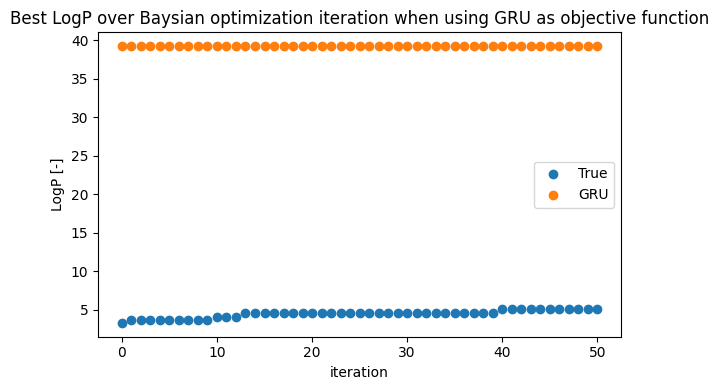

In [73]:
true_list, GRU_list, iter_count = decoderbased_optimizer(DeepGP=gollum_architecture, decoder=GRU_decoder, train_embed_data=train_df["SMILES_embed"], int_key=int_key, iter_budget=config["analysis"]["iter_budget"], initial_sample_num=config["analysis"]["initial_sample_num"], projection_dim=GOLLuM_config["projection_dim"], num_restarts=config["analysis"]["num_restarts"], raw_samples=config["analysis"]["raw_samples"], seed=config["seed"])

true_list = np.asarray([t.detach().cpu().item() if torch.is_tensor(t) else float(t) for t in true_list])
GRU_list = np.asarray([t.detach().cpu().item() if torch.is_tensor(t) else float(t)for t in GRU_list])
iter_count = np.asarray(iter_count)

GRU_objfunc = {"true_list":true_list, "GRU_list":GRU_list, "iter_count":iter_count}
with open("Notebook_result_1/BO_GRU_objfunc.pickle", "wb") as file:
    pickle.dump(GRU_objfunc, file)

plt.figure(figsize=(6, 4))
plt.scatter(iter_count, true_list, label="True")
plt.scatter(iter_count, GRU_list, label="GRU")
plt.legend()
plt.xlabel("iteration")
plt.ylabel("LogP [-]")
plt.title("Best LogP over Baysian optimization iteration when using GRU as objective function")
plt.tight_layout()
plt.savefig("Notebook_result_1/GRU as objective function.png", bbox_inches="tight")
plt.show()

No. of optimization run: 0
No. of optimization run: 1
No. of optimization run: 2
No. of optimization run: 3
No. of optimization run: 4
No. of optimization run: 5
No. of optimization run: 6
No. of optimization run: 7
No. of optimization run: 8
No. of optimization run: 9
No. of optimization run: 10
No. of optimization run: 11
No. of optimization run: 12
No. of optimization run: 13
No. of optimization run: 14
No. of optimization run: 15
No. of optimization run: 16
No. of optimization run: 17
No. of optimization run: 18
No. of optimization run: 19
No. of optimization run: 20
No. of optimization run: 21
No. of optimization run: 22
No. of optimization run: 23
No. of optimization run: 24
No. of optimization run: 25
No. of optimization run: 26
No. of optimization run: 27
No. of optimization run: 28
No. of optimization run: 29
No. of optimization run: 30
No. of optimization run: 31
No. of optimization run: 32
No. of optimization run: 33
No. of optimization run: 34
No. of optimization run: 35
No

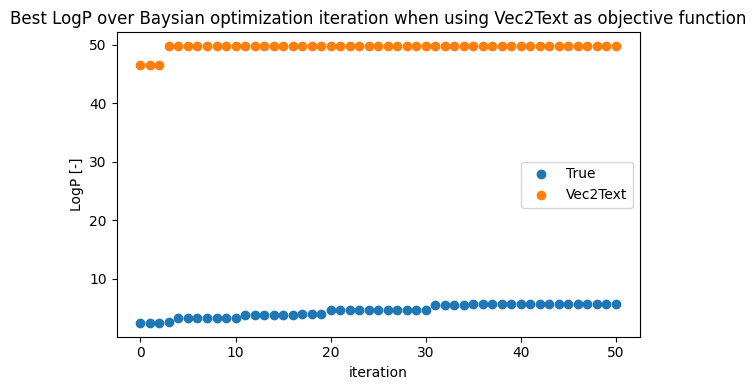

In [ ]:
true_list, Vec2Text_list, iter_count = decoderbased_optimizer(DeepGP=gollum_architecture, decoder=Vec2Text_decoder, train_embed_data=train_df["SMILES_embed"], int_key=int_key, max_loop=config["decoder"]["max_loop"], early_stop_tol=config["decoder"]["early_stop_tol"], patience=config["decoder"]["patience"], iter_budget=config["analysis"]["iter_budget"], initial_sample_num=config["analysis"]["initial_sample_num"], projection_dim=GOLLuM_config["projection_dim"], num_restarts=config["analysis"]["num_restarts"], raw_samples=config["analysis"]["raw_samples"], seed=config["seed"])

true_list = np.asarray([t.detach().cpu().item() if torch.is_tensor(t) else float(t) for t in true_list])
Vec2Text_list = np.asarray([t.detach().cpu().item() if torch.is_tensor(t) else float(t)for t in Vec2Text_list])
iter_count = np.asarray(iter_count)

V2T_objfunc = {"true_list":true_list, "Vec2Text_list":Vec2Text_list, "iter_count":iter_count}
with open("Notebook_result_1/BO_Vec2Text_list_objfunc.pickle", "wb") as file:
    pickle.dump(V2T_objfunc, file)

plt.figure(figsize=(6, 4))
plt.scatter(iter_count, true_list, label="True")
plt.scatter(iter_count, Vec2Text_list, label="Vec2Text")
plt.legend()
plt.xlabel("iteration")
plt.ylabel("LogP [-]")
plt.title("Best LogP over Baysian optimization iteration when using Vec2Text as objective function")
plt.tight_layout()
plt.savefig("Notebook_result_1/Vec2Text as objective function.png", bbox_inches="tight")
plt.show()